# 1. 목표설정


<p>1.   문제 상황

* 산업 현장에서 사용하는 장비에 충격이 가해질 때 발생하는 진동 데이터를 통해 충돌체의 충돌 지점과 질량, 속도와 같은 물리적인 정보를 계산한다.
* 이를 통해 장비에 가해진 충격량을 계산하고, 크기에 따라 등급을 매겨 장비 점검의 필요성을 파악한다.</p>

<p>2.   분석의 가치

* 원자력 발전소 같이 안전 사고 발생시 경제적, 사회적, 환경적으로 피해가 클 수 있는 시설에 적용하면 장비를 적절한 때에 점검하여 사고를 예방할 수 있다.
* 기업에서 사용하는 장비의 경우 고장이나, 너무 잦은 점검은 생산성 저하의 원인이 되므로 이 모델을 통해 경제적인 효율을 높일 수 있다.</p>



# 2. 데이터셋 선정

<p>1. 사용한 데이터셋

*   출처 : https://dacon.io/competitions/official/235614/data
*   2m × 2m × 10mm 평평한 판에 강철구를 질량, 속도, 충돌 지점을 다르게 충돌시킨 진동을 서로 다른 4개의 센서로 측정한 시뮬레이션 데이터
*   시계열 데이터 2800개
*   충돌 지점: 판의 중심이 원점(0,0) / x,y = -400 ~ 400 mm / Δx,Δy = 100mm
*   강구 질량: m = 25 ~ 175g / Δm = 25g
*   충돌 속도: v = 0.2 ~ 1.0 m/s / Δv = 0.2 m/s</p>

<p>2. 데이터셋 선정 이유

*   데이터 셋에서 제공하는 라벨값이 x,y 좌표, 속도, 질량으로 한 데이터 셋에서 다양한 모델링이 가능
*   test 데이터셋의 경우는 임의의 지점, 질량, 속도로 시뮬레이션 한 결과를 모델이 얼마나 잘 예측하는지를 검증하도록 제공
*   대회 데이터이기에 test 데이터셋은 라벨이 제공되지 않아 사용할 수 없음
*   시뮬레이션 데이터에서 나올 수 있는 경우의 수:
( 8 × 8 × 7 × 5 = 2240)
*   9:1의 비율로 train, val, test 셋을 나눌 때
val(280), test(252), train(2268)
*   데이터 양이 부족할 수 있지만 모든 경우의 수 보다 조금 더 많은 데이터를 학습할 수 있어 최소의 요건을 만족한다고 생각









# 3. 머신러닝 문제 정의




<p>1.   문제 정의

*   Linear Regression 기반 회귀 모델을 통해 질량, 속도, 위치에 대한 예측값을 도출하고, 충격량을 계산하여 정해진 위험 정도 이상의 데이터 추출
*   Tree Base 모델을 통해 회귀 문제 해결 or 위험도를 라벨링하여 분류문제로 위험정도 판단<p/>

<p>2.   타겟


*   충돌 지점: x,y 좌표
*   충돌 속도: m/s
*   충돌 질량: g
*   +α)충격량<p/>


<p>3.   가설 설정

*  1) 각 센서에 진동이 도착한 시간으로 충돌 지점을 파악 할 수 있다.


> (1) 노이즈를 고려하여 0이 아닌 시점보다 특정 임계점 이상의 값이 들어오는 시점의 데이터를 사용하는 것이 모델 성능이 더 좋을 것이다.


*  2) Fourier 변환을 통해 얻은 진폭이 클 수록 충돌 속도, 질량이 클 것이다.

> (1) 특정 시점 이후로는 반사된 진동에 의한 노이즈가 측정되어 데이터를 잘라내는 것이 성능이 좋을 것이다.



*  3) Fourier 변환을 통해 얻은 주파수가 원점에서 멀수록 속도, 질량이 클 것이다.<p/>








# 4. 데이터 탐색

In [1]:
!pip3 install xgboost==1.7.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
import pandas as pd
from google.colab import drive
drive.mount('da')

Mounted at da


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, fftshift, ifft

In [4]:
#데이터 불러오기

train_f_o = pd.read_csv('/content/da/MyDrive/235614_진동데이터 활용 충돌체 탐지 AI 경진대회_data/train_features.csv')
train_t_o = pd.read_csv('/content/da/MyDrive/235614_진동데이터 활용 충돌체 탐지 AI 경진대회_data/train_target.csv')
test_data = pd.read_csv('/content/da/MyDrive/235614_진동데이터 활용 충돌체 탐지 AI 경진대회_data/test_features.csv')

In [5]:
#데이터 copy
df_feature = train_f_o.copy()
df_target = train_t_o.copy()

In [6]:
df_feature.shape

(1050000, 6)

In [7]:
df_target.head()

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4


In [8]:
#데이터 살펴보기
#id 하나에 충돌체 한개로 시간에 따른 각 센서에서 측정된 가속도 데이터가 들어있음
# time : 관측시간 / time unit : Second
# s1~s4 : 센서에서 측정된 가속도 / acceleration unit : mm/S^2
df_feature[df_feature['id']== 0]

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.00,0.00,0.00,0.000
1,0,0.000004,0.00,0.00,0.00,0.000
2,0,0.000008,0.00,0.00,0.00,0.000
3,0,0.000012,0.00,0.00,0.00,0.000
4,0,0.000016,0.00,0.00,0.00,0.000
...,...,...,...,...,...,...
370,0,0.001480,-64168.90,-64168.90,52279.59,106792.600
371,0,0.001484,-64236.79,-64236.79,16518.64,58248.420
372,0,0.001488,-63755.95,-63755.95,-25270.30,3015.649
373,0,0.001492,-63020.44,-63020.44,-65904.66,-49795.140


부딪치는 강구의 운동량 feature 생성 후 상위 20% 를 기준으로 1 과 0 으로 구분하여 분류 문제로 접근

In [9]:
# X, Y : 충격 하중이 가해진 좌표 / X, Y unit : mm
# M : 충돌체의 질량 / M unit : g
# v : 충돌체의 충돌 속도 m/s
df_target['P'] = df_target['M']/1000 * df_target['V']
df_target['Caution'] = [0] *len(df_target)
df_target.loc[df_target.query('P >= 0.1').index, 'Caution'] = 1
df_target['Caution'].value_counts(normalize = True)

0    0.771429
1    0.228571
Name: Caution, dtype: float64

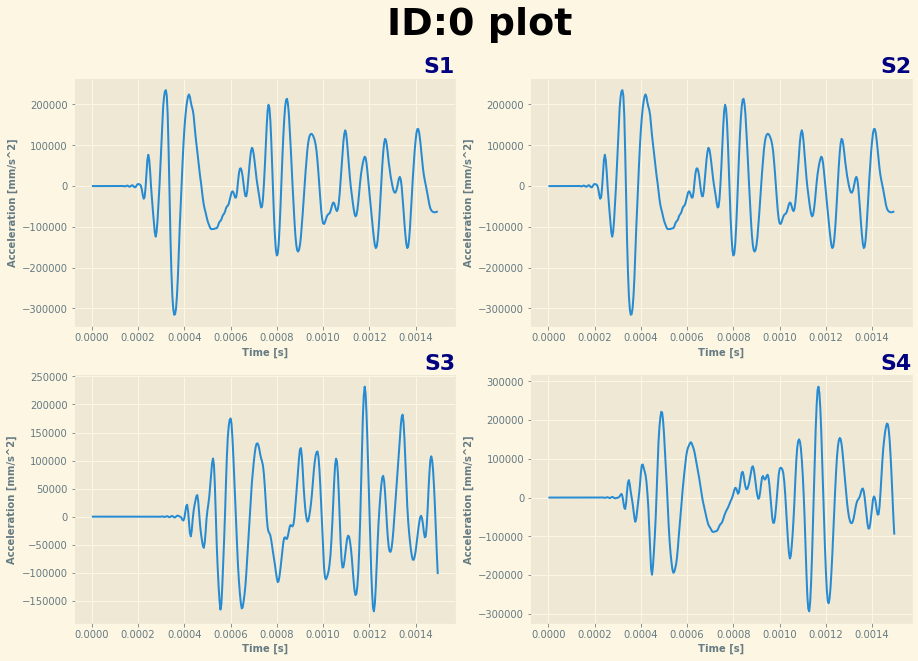

In [10]:
# 데이터 plot을 통해 살펴보기 id : 0


title_font = {
    'fontsize': 22,
    'color' : 'navy',
    'fontweight': 'semibold'
}

label_font ={
    'fontsize':10,
    'fontweight': 'semibold'
}


plt.style.use("Solarize_Light2")
plt.figure(figsize=(15,10))
##S1
plt.subplot(2, 2, 1)
plt.plot(df_feature[df_feature['id']== 0]['Time'], df_feature[df_feature['id']== 0]['S1']);
plt.title('S1', fontdict = title_font, loc='right')
plt.ylabel('Acceleration [mm/s^2]', fontdict = label_font)
plt.xlabel('Time [s]', fontdict = label_font)
##S2
plt.subplot(2, 2, 2)
plt.plot(df_feature[df_feature['id']== 0]['Time'], df_feature[df_feature['id']== 0]['S2']);
plt.title('S2', fontdict = title_font, loc='right')
plt.ylabel('Acceleration [mm/s^2]', fontdict = label_font)
plt.xlabel('Time [s]', fontdict = label_font)
##S3
plt.subplot(2, 2, 3)
plt.plot(df_feature[df_feature['id']== 0]['Time'], df_feature[df_feature['id']== 0]['S3']);
plt.title('S3', fontdict = title_font, loc='right')
plt.ylabel('Acceleration [mm/s^2]', fontdict = label_font)
plt.xlabel('Time [s]', fontdict = label_font)
##s4
plt.subplot(2, 2, 4)
plt.plot(df_feature[df_feature['id']== 0]['Time'], df_feature[df_feature['id']== 0]['S4']);
plt.title('S4', fontdict = title_font, loc='right')
plt.ylabel('Acceleration [mm/s^2]', fontdict = label_font)
plt.xlabel('Time [s]', fontdict = label_font)

plt.suptitle('ID:0 plot', fontsize =38, fontweight= 'bold')
plt.show();




In [11]:
from sklearn.model_selection import train_test_split, cross_val_score 


#데이터 형태 변경 함수 선언
#(index(id), S(0~3), acceleration(0~374)) 형식으로 변경경
def reshape_data(df):
    df_r = np.concatenate([df[s].values.reshape(-1, 375, 1) for s in ["S1", "S2", "S3", "S4"]], axis=-1)
    df_r = df_r.transpose(0, 2, 1)
    return df_r



In [12]:
#형태 변경 함수 적용
X = reshape_data(df_feature)

In [13]:
#train, val, test set 분할
train, val = train_test_split(X, random_state = 2, test_size=0.1)
train, test = train_test_split(train, random_state = 2, test_size=0.1)

#target data split
y_train, y_val = train_test_split(df_target, random_state = 2, test_size=0.1)
y_train, y_test = train_test_split(y_train, random_state = 2, test_size=0.1)

In [14]:
print(train.shape, y_train.shape)
print(y_train['Caution'].value_counts(normalize = True))

(2268, 4, 375) (2268, 7)
0    0.772487
1    0.227513
Name: Caution, dtype: float64


In [15]:
print(val.shape, y_val.shape)
print(y_val['Caution'].value_counts(normalize = True))

(280, 4, 375) (280, 7)
0    0.771429
1    0.228571
Name: Caution, dtype: float64


In [16]:
print(test.shape, y_test.shape)
print(y_test['Caution'].value_counts(normalize = True))

(252, 4, 375) (252, 7)
0    0.761905
1    0.238095
Name: Caution, dtype: float64


## y_val의 데이터와 X_val 데이터가 일치하게 분리 되었는지 확인

In [17]:
#데이터 일치 확인 함수

def confirm(X_df, y_df, y_val_index, s):
  f = np.linspace(0,375,375)
  
  #y_val의 index와 val의 인덱스가 같을 때 데이터가 같음을 확인하고 y_val의 id를 val의 아이디로 사용

  plt.plot(f,df_feature[df_feature['id']==y_df['id'].iloc[y_val_index]][df_feature.columns[s+2]], color = 'red',alpha = 0.3, label='y_val')
  plt.plot(f,X_df[y_val_index,s,:], color = 'blue', alpha = 0.3, label = 'val')
  plt.legend()

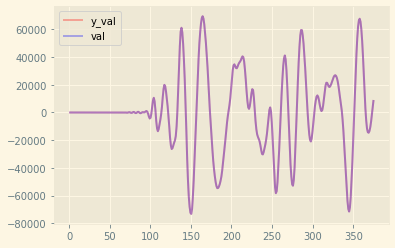

In [18]:
#val 데이터에 대해 확인(빨간색, 파란색에 alpha를 주어 색이 합쳐져 보라색으로 보임을 확인)

confirm(val, y_val, 3, 0)

## 반사파에 의한 노이즈 제거 함수

In [19]:
# 뒷부분 노이즈 제거 함수
def noise_delete(df, start_index, finish_index):
  df_new = df.copy()[:,:,start_index:finish_index]
  return df_new

In [20]:
#50 ticks
train_50 = noise_delete(train, 0, 50)
val_50 = noise_delete(val, 0, 50)
test_50 = noise_delete(test, 0, 50)

In [21]:
#100 ticks
train_100 = noise_delete(train, 0, 100)
val_100 = noise_delete(val, 0, 100)
test_100 = noise_delete(test, 0, 100)

In [22]:
#150 ticks
train_150 = noise_delete(train, 0, 150)
val_150 = noise_delete(val, 0, 150)
test_150 = noise_delete(test, 0, 150)

In [23]:
#200 ticks
train_200 = noise_delete(train, 0, 200)
val_200 = noise_delete(val, 0, 200)
test_200 = noise_delete(test, 0, 200)

# 5. Feature engineering

## max_amplitude, mean_amplitude, max_amplitude_point_frequency

In [24]:
#FFT 후 최대, 평균균 진폭 도출 함수

def feature_generation(df, y_df):
  d=pd.DataFrame()
  d1=pd.DataFrame()
  d2=pd.DataFrame()
  d3=pd.DataFrame()
  for j in range(df.shape[1]):
    for i in range(df.shape[0]):

      #상수 설정
      n = len(df[i,j,:])  # length of signal
      fs = 250000 # sampling frequency
      T = 1/fs # sampling preiod
      x = np.linspace(0.0, n*T, endpoint = False) #time vector
      
      #fft
      yf = fft(df.copy()[i,j,:]/1000)
      xf = fftfreq(n, T) # Discrete Fourier Transform sample frequencies
      xf = fftshift(xf) #Shift the zero-frequency component to the center of the spectrum.
      yplot = fftshift(yf)
      fr_fft = 1.0/n * np.abs(yplot) #final result of fft

      #feature 생성
      max = (fr_fft).max()
      mean = (fr_fft).mean()
      max_amp_point = np.where(fr_fft == max)
      max_amp_point_freq = abs(xf[max_amp_point][0])
      
      #dataframe 생성
      d1.loc[i,j] = max
      d2.loc[i,j] = mean
      d3.loc[i,j] = max_amp_point_freq
  d1.columns=['max_amp_S1','max_amp_S2','max_amp_S3','max_amp_S4']
  d2.columns=['mean_amp_S1', 'mean_amp_S2', 'mean_amp_S3', 'mean_amp_S4']
  d3.columns=["MAP_freq_S1", "MAP_freq_S2", "MAP_freq_S3", "MAP_freq_S4"]
  d = pd.concat([d1,d2,d3], axis = 1)
  
  d.index = y_df.index
  return d 

In [25]:
#함수 적용
X_train_50 = feature_generation(train_50, y_train)
X_train_50.columns=['max_amp_50_S1','max_amp_50_S2','max_amp_50_S3','max_amp_50_S4', 'mean_amp_50_S1', 'mean_amp_50_S2', 'mean_amp_50_S3', 'mean_amp_50_S4', "MAP_freq_50_S1", "MAP_freq_50_S2", "MAP_freq_50_S3", "MAP_freq_50_S4"]

X_val_50 = feature_generation(val_50, y_val)
X_val_50.columns=['max_amp_50_S1','max_amp_50_S2','max_amp_50_S3','max_amp_50_S4', 'mean_amp_50_S1', 'mean_amp_50_S2', 'mean_amp_50_S3', 'mean_amp_50_S4', "MAP_freq_50_S1", "MAP_freq_50_S2", "MAP_freq_50_S3", "MAP_freq_50_S4"]

X_test_50 = feature_generation(test_50, y_test)
X_test_50.columns=['max_amp_50_S1','max_amp_50_S2','max_amp_50_S3','max_amp_50_S4', 'mean_amp_50_S1', 'mean_amp_50_S2', 'mean_amp_50_S3', 'mean_amp_50_S4', "MAP_freq_50_S1", "MAP_freq_50_S2", "MAP_freq_50_S3", "MAP_freq_50_S4"]

In [26]:
X_train_100 = feature_generation(train_100, y_train)
X_train_100.columns=['max_amp_100_S1','max_amp_100_S2','max_amp_100_S3','max_amp_100_S4', 'mean_amp_100_S1', 'mean_amp_100_S2', 'mean_amp_100_S3', 'mean_amp_100_S4', "MAP_freq_100_S1", "MAP_freq_100_S2", "MAP_freq_100_S3", "MAP_freq_100_S4"]

X_val_100= feature_generation(val_100, y_val)
X_val_100.columns=['max_amp_100_S1','max_amp_100_S2','max_amp_100_S3','max_amp_100_S4', 'mean_amp_100_S1', 'mean_amp_100_S2', 'mean_amp_100_S3', 'mean_amp_100_S4', "MAP_freq_100_S1", "MAP_freq_100_S2", "MAP_freq_100_S3", "MAP_freq_100_S4"]

X_test_100 = feature_generation(test_100, y_test)
X_test_100.columns=['max_amp_100_S1','max_amp_100_S2','max_amp_100_S3','max_amp_100_S4', 'mean_amp_100_S1', 'mean_amp_100_S2', 'mean_amp_100_S3', 'mean_amp_100_S4', "MAP_freq_100_S1", "MAP_freq_100_S2", "MAP_freq_100_S3", "MAP_freq_100_S4"]


In [27]:
X_train_150 = feature_generation(train_150, y_train)
X_train_150.columns=['max_amp_150_S1','max_amp_150_S2','max_amp_150_S3','max_amp_150_S4', 'mean_amp_150_S1', 'mean_amp_150_S2', 'mean_amp_150_S3', 'mean_amp_150_S4', "MAP_freq_150_S1", "MAP_freq_150_S2", "MAP_freq_150_S3", "MAP_freq_150_S4"]

X_val_150 = feature_generation(val_150, y_val)
X_val_150.columns=['max_amp_150_S1','max_amp_150_S2','max_amp_150_S3','max_amp_150_S4', 'mean_amp_150_S1', 'mean_amp_150_S2', 'mean_amp_150_S3', 'mean_amp_150_S4', "MAP_freq_150_S1", "MAP_freq_150_S2", "MAP_freq_150_S3", "MAP_freq_150_S4"]

X_test_150 = feature_generation(test_150, y_test)
X_test_150.columns=['max_amp_150_S1','max_amp_150_S2','max_amp_150_S3','max_amp_150_S4', 'mean_amp_150_S1', 'mean_amp_150_S2', 'mean_amp_150_S3', 'mean_amp_150_S4', "MAP_freq_150_S1", "MAP_freq_150_S2", "MAP_freq_150_S3", "MAP_freq_150_S4"]

In [28]:
X_train_200 = feature_generation(train_200, y_train)
X_train_200.columns=['max_amp_200_S1','max_amp_200_S2','max_amp_200_S3','max_amp_200_S4', 'mean_amp_200_S1', 'mean_amp_200_S2', 'mean_amp_200_S3', 'mean_amp_200_S4', "MAP_freq_200_S1", "MAP_freq_200_S2", "MAP_freq_200_S3", "MAP_freq_200_S4"]

X_val_200 = feature_generation(val_200, y_val)
X_val_200.columns=['max_amp_200_S1','max_amp_200_S2','max_amp_200_S3','max_amp_200_S4', 'mean_amp_200_S1', 'mean_amp_200_S2', 'mean_amp_200_S3', 'mean_amp_200_S4', "MAP_freq_200_S1", "MAP_freq_200_S2", "MAP_freq_200_S3", "MAP_freq_200_S4"]

X_test_200 = feature_generation(test_200, y_test)
X_test_200.columns=['max_amp_200_S1','max_amp_200_S2','max_amp_200_S3','max_amp_200_S4', 'mean_amp_200_S1', 'mean_amp_200_S2', 'mean_amp_200_S3', 'mean_amp_200_S4', "MAP_freq_200_S1", "MAP_freq_200_S2", "MAP_freq_200_S3", "MAP_freq_200_S4"]


In [29]:
X_train_375 = feature_generation(train, y_train)
X_train_375.columns=['max_amp_375_S1','max_amp_375_S2','max_amp_375_S3','max_amp_375_S4', 'mean_amp_375_S1', 'mean_amp_375_S2', 'mean_amp_375_S3', 'mean_amp_375_S4', "MAP_freq_375_S1", "MAP_freq_375_S2", "MAP_freq_375_S3", "MAP_freq_375_S4"]

X_val_375 = feature_generation(val, y_val)
X_val_375.columns=['max_amp_375_S1','max_amp_375_S2','max_amp_375_S3','max_amp_375_S4', 'mean_amp_375_S1', 'mean_amp_375_S2', 'mean_amp_375_S3', 'mean_amp_375_S4', "MAP_freq_375_S1", "MAP_freq_375_S2", "MAP_freq_375_S3", "MAP_freq_375_S4"]

X_test_375 = feature_generation(test, y_test)
X_test_375.columns=['max_amp_375_S1','max_amp_375_S2','max_amp_375_S3','max_amp_375_S4', 'mean_amp_375_S1', 'mean_amp_375_S2', 'mean_amp_375_S3', 'mean_amp_375_S4', "MAP_freq_375_S1", "MAP_freq_375_S2", "MAP_freq_375_S3", "MAP_freq_375_S4"]


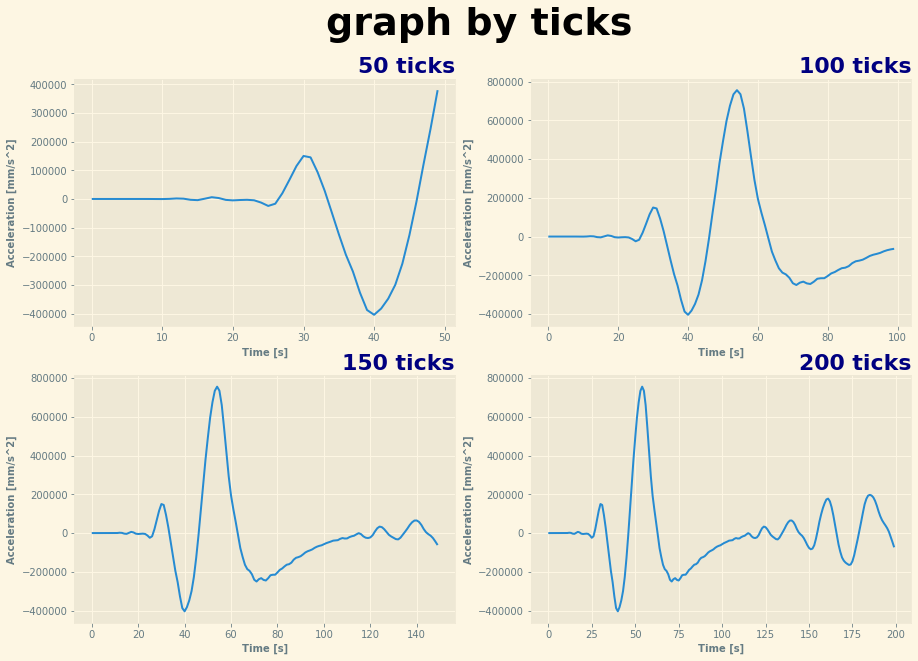

In [30]:
plt.figure(figsize=(15,10))
##50
plt.subplot(2, 2, 1)
plt.plot(train_50[0,0,:]);
plt.title('50 ticks', fontdict = title_font, loc='right')
plt.ylabel('Acceleration [mm/s^2]', fontdict = label_font)
plt.xlabel('Time [s]', fontdict = label_font)
##100
plt.subplot(2, 2, 2)
plt.plot(train_100[0,0,:]);
plt.title('100 ticks', fontdict = title_font, loc='right')
plt.ylabel('Acceleration [mm/s^2]', fontdict = label_font)
plt.xlabel('Time [s]', fontdict = label_font)
##150
plt.subplot(2, 2, 3)
plt.plot(train_150[0,0,:]);
plt.title('150 ticks', fontdict = title_font, loc='right')
plt.ylabel('Acceleration [mm/s^2]', fontdict = label_font)
plt.xlabel('Time [s]', fontdict = label_font)
##200
plt.subplot(2, 2, 4)
plt.plot(train_200[0,0,:]);
plt.title('200 ticks', fontdict = title_font, loc='right')
plt.ylabel('Acceleration [mm/s^2]', fontdict = label_font)
plt.xlabel('Time [s]', fontdict = label_font)

plt.suptitle('graph by ticks', fontsize =38, fontweight= 'bold')
plt.show();


## first point above threshold

In [31]:
#처음 theshold 이상의 값에 도달한 시점 도출하는 함수

def first_threshold(df, y_df, threshold):
  d = pd.DataFrame()
  for j in range(df.shape[1]):
    for i in range(df.shape[0]):
      n_i_j = np.where(abs(df[i,j]/1000)>threshold)[0][0]
      d.loc[i,j] = n_i_j
  d.columns=['S1_thr','S2_thr','S3_thr','S4_thr']
  d.index = y_df.index
  d['S1-S2'] = abs(d['S1_thr'] - d['S2_thr'])
  d['S1-S3'] = abs(d['S1_thr'] - d['S3_thr'])
  d['S1-S4'] = abs(d['S1_thr'] - d['S4_thr'])
  d['S2-S3'] = abs(d['S2_thr'] - d['S3_thr'])
  d['S2-S4'] = abs(d['S2_thr'] - d['S4_thr'])
  d['S3-S4'] = abs(d['S3_thr'] - d['S4_thr'])
  return d

In [32]:
#featrue 생성

thr_train = first_threshold(train, y_train, 0)
thr_val = first_threshold(val, y_val, 0)
thr_test = first_threshold(test, y_test, 0)

threshold 탐색

Text(0.5, 1.0, 'First signal detected time')

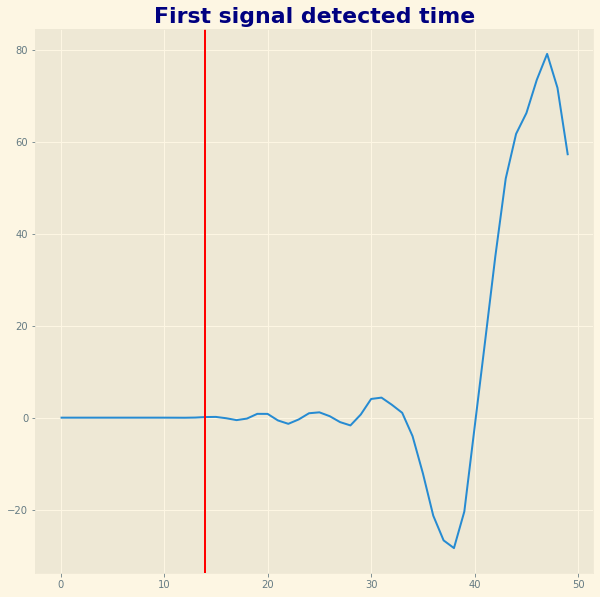

In [33]:
plt.figure(figsize = (10,10))
plt.plot(train_50[1,0]/1000)
plt.axvline(x=np.where(abs((train_50[1,0])/1000)>0.10)[0][0], c = 'red')
plt.title('First signal detected time', fontdict = title_font)

## max_amplitude point frequency


fast fourier transform graph 탐색

In [34]:
#fft plot 함수

def fft_plot(df, id, s):
  #상수 설정
  n = len(df[id,s,:])  # length of signal
  fs = 250000 # sampling frequency
  T = 1/fs # sampling preiod
  x = np.linspace(0.0, n*T, endpoint = False) #time vector
  
  #fft
  yf = fft(df.copy()[id,s,:]/1000) #fft
  xf = fftfreq(n, T) # Discrete Fourier Transform sample frequencies
  xf = fftshift(xf) #Shift the zero-frequency component to the center of the spectrum
  yplot = fftshift(yf)
  fr_fft = 1.0/n * np.abs(yplot) #final result of fft
  
  #feature 생성
  mean = (fr_fft).mean() 
  max = (fr_fft).max()
  max_amp_point = np.where(fr_fft == max)
  max_amp_point_freq = xf[max_amp_point]

  #fft plot(max, mean)
  plt.stem(xf, fr_fft, use_line_collection = True)
  
  for i in max_amp_point[0]:
    plt.axvline(xf[i], c= 'r')
  plt.axhline(mean, c= 'green')
  return plt.show();

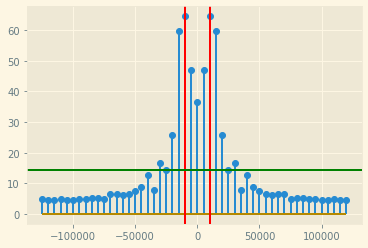

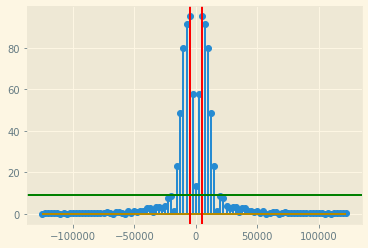

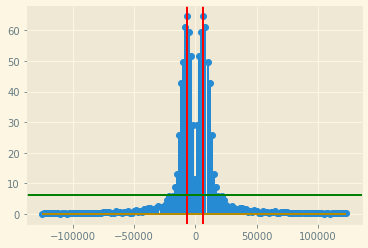

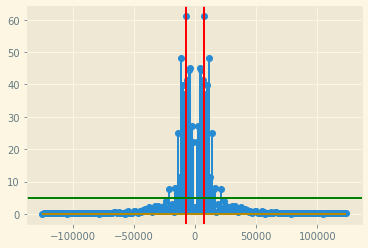

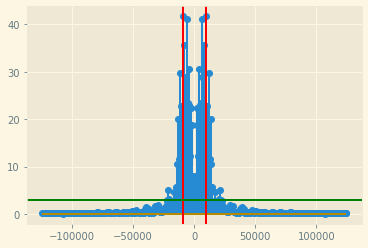

In [35]:
fft_plot(train_50, 0,0)
fft_plot(train_100, 0,0)
fft_plot(train_150, 0,0)
fft_plot(train_200, 0,0)
fft_plot(train, 0,0)

Text(0.5, 1.0, 'raw data')

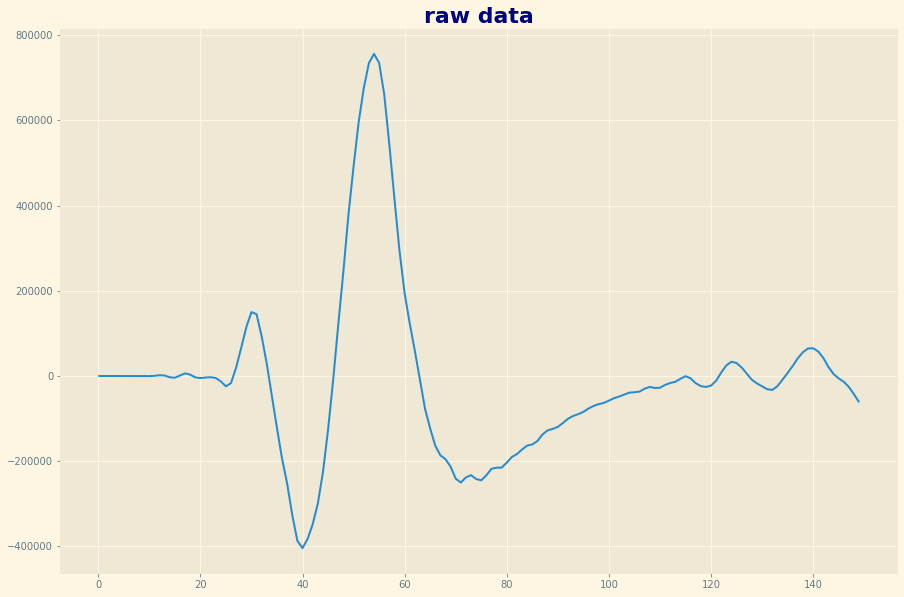

In [36]:
plt.figure(figsize = (15,10))
plt.plot(train_150[0,0,:])
plt.title('raw data', fontdict = title_font)

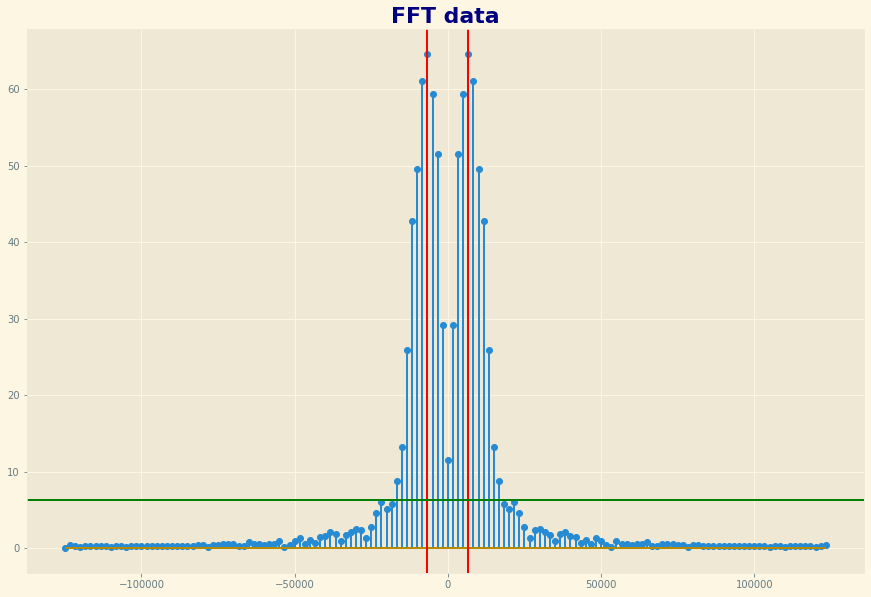

In [37]:
plt.figure(figsize = (15,10))
plt.title('FFT data', fontdict = title_font)
fft_plot(train_150, 0,0)


In [38]:
"""
#data size에 따른 특성들의 변화 탐색

title_font = {
    'fontsize': 22,
    'color' : 'navy',
    'fontweight': 'semibold'
}

plt.style.use("Solarize_Light2")
plt.figure(figsize=(12,8))


plt.subplot(2, 2, 1)
plt.plot([50, 100, 150, 200, 375],[X_train['max_amp_50_S1'][0], X_train['max_amp_100_S1'][0], X_train['max_amp_150_S1'][0], X_train['max_amp_200_S1'][0], X_train['max_amp_375_S1'][0]], c = 'orangered')
plt.xticks([50, 100, 150, 200, 375])
plt.title('max_amp', fontdict = title_font)


plt.subplot(2, 2, 2)
plt.plot([50, 100, 150, 200, 375],[X_train['MAP_freq_50_S1'][0], X_train['MAP_freq_100_S1'][0], X_train['MAP_freq_150_S1'][0], X_train['MAP_freq_200_S1'][0], X_train['MAP_freq_375_S1'][0]], c = 'orangered')
plt.xticks([50, 100, 150, 200, 375])
plt.title('MAP_freq', fontdict = title_font)


plt.subplot(2, 2, 3)
plt.plot([50, 100, 150, 200, 375],[X_train['mean_amp_50_S1'][0], X_train['mean_amp_100_S1'][0], X_train['mean_amp_150_S1'][0], X_train['mean_amp_200_S1'][0], X_train['mean_amp_375_S1'][0]], c = 'orangered')
plt.xticks([50, 100, 150, 200, 375])
plt.title('mean_amp', fontdict = title_font)

plt.show();
"""

'\n#data size에 따른 특성들의 변화 탐색\n\ntitle_font = {\n    \'fontsize\': 22,\n    \'color\' : \'navy\',\n    \'fontweight\': \'semibold\'\n}\n\nplt.style.use("Solarize_Light2")\nplt.figure(figsize=(12,8))\n\n\nplt.subplot(2, 2, 1)\nplt.plot([50, 100, 150, 200, 375],[X_train[\'max_amp_50_S1\'][0], X_train[\'max_amp_100_S1\'][0], X_train[\'max_amp_150_S1\'][0], X_train[\'max_amp_200_S1\'][0], X_train[\'max_amp_375_S1\'][0]], c = \'orangered\')\nplt.xticks([50, 100, 150, 200, 375])\nplt.title(\'max_amp\', fontdict = title_font)\n\n\nplt.subplot(2, 2, 2)\nplt.plot([50, 100, 150, 200, 375],[X_train[\'MAP_freq_50_S1\'][0], X_train[\'MAP_freq_100_S1\'][0], X_train[\'MAP_freq_150_S1\'][0], X_train[\'MAP_freq_200_S1\'][0], X_train[\'MAP_freq_375_S1\'][0]], c = \'orangered\')\nplt.xticks([50, 100, 150, 200, 375])\nplt.title(\'MAP_freq\', fontdict = title_font)\n\n\nplt.subplot(2, 2, 3)\nplt.plot([50, 100, 150, 200, 375],[X_train[\'mean_amp_50_S1\'][0], X_train[\'mean_amp_100_S1\'][0], X_train[\'mean_am

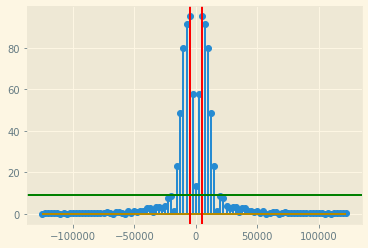

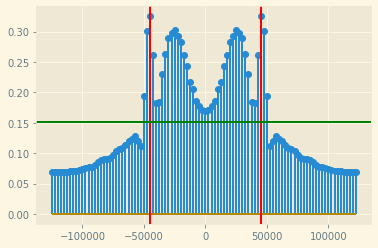

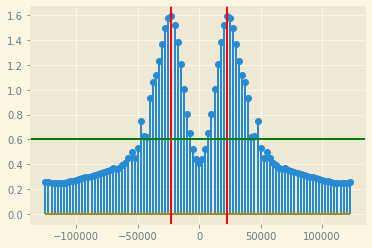

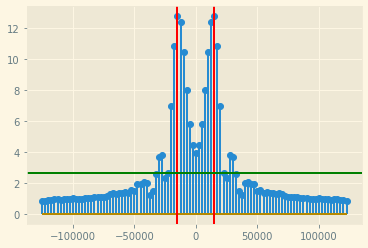

In [39]:
#동일 size, id 일때, s에 따른 fft 그래프 
fft_plot(train_100, 0,0)
fft_plot(train_100, 0,1)
fft_plot(train_100, 0,2)
fft_plot(train_100, 0,3)

In [40]:
#동일 size, id 일때, s에 따른 특성 변화
"""

title_font = {
    'fontsize': 22,
    'color' : 'navy',
    'fontweight': 'semibold'
}

plt.style.use("Solarize_Light2")
plt.figure(figsize=(12,8))


plt.subplot(2, 2, 1)
plt.plot(['S1','S2','S3', 'S4'],[X_train['max_amp_100_S1'].iloc[[0]], X_train['max_amp_100_S2'].iloc[[0]], X_train['max_amp_100_S3'].iloc[[0]], X_train['max_amp_100_S4'].iloc[[0]]], c = 'orangered')
plt.xticks(['S1','S2','S3', 'S4'])
plt.title('max_amp', fontdict = title_font)


plt.subplot(2, 2, 2)
plt.plot(['S1','S2','S3', 'S4'],[X_train['MAP_freq_100_S1'].iloc[[0]], X_train['MAP_freq_100_S2'].iloc[[0]], X_train['MAP_freq_100_S3'].iloc[[0]], X_train['MAP_freq_100_S4'].iloc[[0]]], c = 'orangered')
plt.xticks(['S1','S2','S3', 'S4'])
plt.title('MAP_freq', fontdict = title_font)


plt.subplot(2, 2, 3)
plt.plot(['S1','S2','S3', 'S4'],[X_train['mean_amp_100_S1'].iloc[[0]], X_train['mean_amp_100_S2'].iloc[[0]], X_train['mean_amp_100_S3'].iloc[[0]], X_train['mean_amp_100_S4'].iloc[[0]]], c = 'orangered')
plt.xticks(['S1','S2','S3', 'S4'])
plt.title('mean_amp', fontdict = title_font)

plt.show();
"""

'\n\ntitle_font = {\n    \'fontsize\': 22,\n    \'color\' : \'navy\',\n    \'fontweight\': \'semibold\'\n}\n\nplt.style.use("Solarize_Light2")\nplt.figure(figsize=(12,8))\n\n\nplt.subplot(2, 2, 1)\nplt.plot([\'S1\',\'S2\',\'S3\', \'S4\'],[X_train[\'max_amp_100_S1\'].iloc[[0]], X_train[\'max_amp_100_S2\'].iloc[[0]], X_train[\'max_amp_100_S3\'].iloc[[0]], X_train[\'max_amp_100_S4\'].iloc[[0]]], c = \'orangered\')\nplt.xticks([\'S1\',\'S2\',\'S3\', \'S4\'])\nplt.title(\'max_amp\', fontdict = title_font)\n\n\nplt.subplot(2, 2, 2)\nplt.plot([\'S1\',\'S2\',\'S3\', \'S4\'],[X_train[\'MAP_freq_100_S1\'].iloc[[0]], X_train[\'MAP_freq_100_S2\'].iloc[[0]], X_train[\'MAP_freq_100_S3\'].iloc[[0]], X_train[\'MAP_freq_100_S4\'].iloc[[0]]], c = \'orangered\')\nplt.xticks([\'S1\',\'S2\',\'S3\', \'S4\'])\nplt.title(\'MAP_freq\', fontdict = title_font)\n\n\nplt.subplot(2, 2, 3)\nplt.plot([\'S1\',\'S2\',\'S3\', \'S4\'],[X_train[\'mean_amp_100_S1\'].iloc[[0]], X_train[\'mean_amp_100_S2\'].iloc[[0]], X_trai

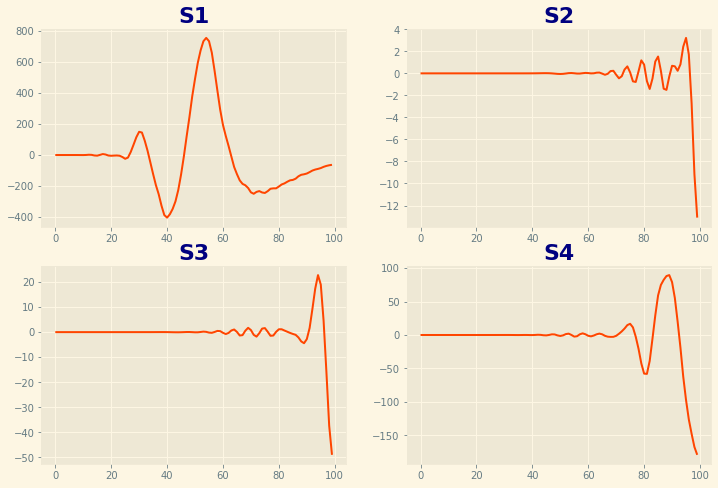

In [41]:

plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(train_100[0,0,:]/1000, c = 'orangered')
plt.title('S1', fontdict = title_font)
plt.subplot(2, 2, 2)
plt.plot(train_100[0,1,:]/1000, c = 'orangered')
plt.title('S2', fontdict = title_font)
plt.subplot(2, 2, 3)
plt.plot(train_100[0,2,:]/1000, c = 'orangered')
plt.title('S3', fontdict = title_font)
plt.subplot(2, 2, 4)
plt.plot(train_100[0,3,:]/1000, c = 'orangered')
plt.title('S4', fontdict = title_font)
plt.show();


*   하나의 시계열 데이터에서 선택한 데이터의 개수에 따라 진폭의 최댓값과 최댓값 일 때의 주파수 값이 변하는 것을 볼 수 있다.
*   scipy.fft 공식문서(https://docs.scipy.org/doc/scipy/tutorial/fft.html) 예제 코드에서 진폭을 계산할 때 FFT한 결과 값에서 샘플링한 데이터의 개수 n으로 나눠주는데, 이에 따라 발생하는 결과로 이해된다.
*   FFT를 진행하는 과정에서 n으로 나눠주는 수식이 도출되는 것으로 보이지만, 수식을 완전히 이해하지는 못했다.
*   샘플링한 데이터 개수 n에 따라 진폭이 변하는 것이 직관적으로 이해되지 않아 추가적인 공부가 필요하다.
*   데이터 개수가 동일할 때, 센서별 FFT 진폭은 각 센서에 측정된 변환전 진폭과 비슷한 스케일로 차이가 남을 확인하였다.
*   위와 같은 이유로 데이터의 개수가 일정할 때, 진폭의 크기를 통해 타겟값을 추론하는 것이 가능하다고 판단하였다.
*   추가적인 도메인 지식 학습과 경험으로 FFT에 대한 이해를 높일 필요가 있다.



# 6. modeling

In [42]:
#feature data 통합

X_train = pd.concat([X_train_50, X_train_100, X_train_150, X_train_200, X_train_375, thr_train], axis = 1)
X_val = pd.concat([X_val_50, X_val_100, X_val_150, X_val_200, X_val_375, thr_val], axis = 1)
X_test = pd.concat([X_test_50, X_test_100, X_test_150, X_test_200, X_test_375, thr_test], axis = 1)


In [43]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2268, 70)
(280, 70)
(252, 70)


In [44]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from xgboost import XGBClassifier



#회귀 모델 성능 평가 함수 선언

def eval_models(y_pred, y_real):
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    return mse, rmse, mae, r2

#회귀 모델 성능 print 함수 선언

def print_score(y_pred, y_real, x, model, settype):
  print(settype, 'set', x, ' position ', model,'mse ', eval_models(y_pred, y_real[x])[0])
  print(settype, 'set', x, ' position ', model,'rmse ', eval_models(y_pred, y_real[x])[1])
  print(settype, 'set', x, ' position ', model,'mae ', eval_models(y_pred, y_real[x])[2])
  print(settype, 'set', x, ' position ', model,'r2 ', eval_models(y_pred, y_real[x])[3])


# 회귀계수 탐색 함수 선언

def make_coef_df(lin_model):
  d = pd.DataFrame()
  d['abs_coef'] = pd.DataFrame(abs(lin_model.coef_))
  d['coef'] = pd.DataFrame(lin_model.coef_)
  return d

#회귀 모델 성능 평가 함수 선언
def eval_models2(y_pred, y_real):
  recall = recall_score(y_real, y_pred)
  precision = precision_score(y_real, y_pred)
  f1 = f1_score(y_real, y_pred)
  return recall, precision, f1

#roc_auc는 pred proba를 사용해야 하므로 함수에 넣지 않고 따로 계산해주어야함함

#분류 모델 성능 print 함수 선언

def print_score2(y_pred, y_real, model):
  print('Caution label predict', model,'recall ', eval_models2(y_pred, y_real['Caution'])[0])
  print('Caution label predict', model,'precision ', eval_models2(y_pred, y_real['Caution'])[1])
  print('Caution label predict', model,'f1 ', eval_models2(y_pred, y_real['Caution'])[2])




## baseline

X, Y position 예측 모델

*   타겟 유형: 연속적인 실수
*   문제 성격: 회귀 문제
*   평가 지표: mse, rmse, mae, r2
*   baseline: 평균





In [45]:
#회귀 모델 baseline

# X position
X_pos_train_mean = y_train['X'].mean()
X_pos_train_baseline = [X_pos_train_mean] * len(y_train['X'])

X_pos_val_mean = y_val['X'].mean()
X_pos_val_baseline = [X_pos_val_mean] * len(y_val['X'])

X_pos_train_base_score = pd.DataFrame(eval_models(X_pos_train_baseline, y_train['X']))
X_pos_train_base_score.columns = ['X_pos_train_base_score']
X_pos_train_base_score.index = ['mse', 'rmse', 'mae', 'r2']

X_pos_val_base_score = pd.DataFrame(eval_models(X_pos_val_baseline, y_val['X']))
X_pos_val_base_score.columns = ['X_pos_val_base_score']
X_pos_val_base_score.index = ['mse', 'rmse', 'mae', 'r2']

print_score(X_pos_train_baseline, y_train, 'X', 'baseline', 'train')
print_score(X_pos_val_baseline, y_val, 'X', 'baseline','val')

train set X  position  baseline mse  66590.29352481735
train set X  position  baseline rmse  258.05095141234676
train set X  position  baseline mae  223.4357940707147
train set X  position  baseline r2  0.0
val set X  position  baseline mse  73341.70918367348
val set X  position  baseline rmse  270.81674465156965
val set X  position  baseline mae  237.9974489795918
val set X  position  baseline r2  0.0


In [46]:
X_pos_val_base_score

,X_pos_val_base_score
mse,73341.709184
rmse,270.816745
mae,237.997449
r2,0.000000


In [47]:
print(round(X_pos_val_mean,2))


-13.93


In [48]:
# Y position
Y_pos_train_mean = y_train['Y'].mean()
Y_pos_train_baseline = [Y_pos_train_mean] * len(y_train['Y'])

Y_pos_val_mean = y_val['Y'].mean()
Y_pos_val_baseline = [Y_pos_val_mean] * len(y_val['Y'])

Y_pos_train_base_score = pd.DataFrame(eval_models(Y_pos_train_baseline, y_train['Y']))
Y_pos_train_base_score.columns = ['Y_pos_train_base_score']
Y_pos_train_base_score.index = ['mse', 'rmse', 'mae', 'r2']

Y_pos_val_base_score = pd.DataFrame(eval_models(Y_pos_val_baseline, y_val['Y']))
Y_pos_val_base_score.columns = ['Y_pos_val_base_score']
Y_pos_val_base_score.index = ['mse', 'rmse', 'mae', 'r2']

print_score(Y_pos_train_baseline, y_train, 'Y','baseline', 'train')
print_score(Y_pos_val_baseline, y_val, 'Y','baseline', 'val')

train set Y  position  baseline mse  65752.21080659059
train set Y  position  baseline rmse  256.42193901183765
train set Y  position  baseline mae  220.67613510882177
train set Y  position  baseline r2  0.0
val set Y  position  baseline mse  65306.122448979586
val set Y  position  baseline rmse  255.55062599997595
val set Y  position  baseline mae  225.35714285714286
val set Y  position  baseline r2  0.0


In [49]:
print(round(Y_pos_val_mean,2))

7.14


In [50]:
Y_pos_train_base_score

,Y_pos_train_base_score
mse,65752.210807
rmse,256.421939
mae,220.676135
r2,0.000000


xgboost Caution label 분류 예측 모델

*   타겟 유형: 0,1 로 구별된 이진항
*   문제 성격: 분류 문제
<br/>caution-1(손상의 위험이 높음) : true
<br/>caution-0(손상의 위험이 적음) : false
*   평가 지표: recall, f1 score, precision, roc_auc_score
<br/>recall이 더 중요한 이유: 실제 caution이지만 아니라고 분류할 경우(FN) 기계 손상이 누적될 수 있어 recall이 더 중요함
*   baseline: 최빈값




In [51]:
#caution baseline

cau_train_base = [0] * len(y_train['Caution'])
cau_val_base = [0] * len(y_val['Caution'])
print('train baseline accuracy: ', accuracy_score(y_train['Caution'], cau_train_base))
print('val baseline accuracy: ', accuracy_score(y_val['Caution'], cau_val_base))

train baseline accuracy:  0.7724867724867724
val baseline accuracy:  0.7714285714285715


precision은 1(true)로 판단한 것 중 진짜 1의 비율인데 baseline은 1로 예측한 값이 없어 분모가 0으로 수학적으로 존재하지 않는 값이 된다.
<br/>recall은 실제 1(true)인 것 중 1로 판단한 것의 비율인데 baseline은 1로 예측한 값이 없어 0이 된다.
즉, baseline에 대해서는 정확도로 점수를 표시하고 이후 모델에서는 앞서 정의한 함수를 사용한다.

## 1) multiple linear regression(x_pos, y_pos)

In [52]:
#스케일링
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)


## 다중 선형 회귀 OLS X position 예측

In [53]:
#다중 선형 회귀 모델


#모델 학습
X_pos_multi = LinearRegression()
X_pos_multi.fit(X_train_s, y_train['X'])

#예측
X_pos_train_multi_pred = X_pos_multi.predict(X_train_s)
X_pos_train_multi_score = pd.DataFrame(eval_models(X_pos_train_multi_pred, y_train['X']))
X_pos_train_multi_score.columns = ['X_pos_train_multi_score']
X_pos_train_multi_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_train_multi_pred, y_train, 'X','mutiple linear regression', 'train')


X_pos_val_multi_pred = X_pos_multi.predict(X_val_s)
X_pos_val_multi_score = pd.DataFrame(eval_models(X_pos_val_multi_pred, y_val['X']))
X_pos_val_multi_score.columns = ['X_pos_val_multi_score']
X_pos_val_multi_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_val_multi_pred, y_val, 'X','mutiple linear regression', 'val')




train set X  position  mutiple linear regression mse  183.34196019678063
train set X  position  mutiple linear regression rmse  13.540382572024345
train set X  position  mutiple linear regression mae  10.184178622658912
train set X  position  mutiple linear regression r2  0.9972467164433139
val set X  position  mutiple linear regression mse  221.3453770572613
val set X  position  mutiple linear regression rmse  14.877680499905262
val set X  position  mutiple linear regression mae  10.924533887213729
val set X  position  mutiple linear regression r2  0.9969819986536865


In [54]:
#다중 선형 회귀 상관계수 히트맵
"""
plt.figure(figsize = (100, 100))
colormap = plt.cm.PuBu
sns.heatmap(X_train.corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})
"""

'\nplt.figure(figsize = (100, 100))\ncolormap = plt.cm.PuBu\nsns.heatmap(X_train.corr(), linewidths = 0.1, vmax = 1.0,\n           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})\n'

In [55]:
#다중 선형 회귀 표준화 회귀 계수 확인

multi_coef_x_pos = make_coef_df(X_pos_multi)
multi_coef_x_pos.index = X_train.columns
multi_coef_x_pos.sort_values('coef', ascending = False, inplace =True)
multi_coef_x_pos


,abs_coef,coef
S3_thr,9.262551e+13,9.262551e+13
S1_thr,1.338164e+02,1.338164e+02
mean_amp_150_S2,3.999776e+01,3.999776e+01
max_amp_150_S1,2.071646e+01,2.071646e+01
MAP_freq_150_S1,1.546261e+01,1.546261e+01
...,...,...
max_amp_150_S2,2.606493e+01,-2.606493e+01
mean_amp_150_S1,3.387592e+01,-3.387592e+01
S2_thr,1.342829e+02,-1.342829e+02
S3-S4,2.144751e+13,-2.144751e+13


*   heatmap 을 분석한 결과 mean amplitude와 max amplitude 간에 상관관계가 너무 높아 각 특성의 독립성을 해친다고 판단 max만 사용함
*   모델의 경제성을 높이기 위해 표준화 회귀계수가 1보다 작은 컬럼 삭제


In [56]:
#불필요한 column 삭제

X_train_re = X_train.copy().drop(columns = X_train.columns[X_train.columns.str.contains('mean')])
X_val_re = X_val.copy().drop(columns = X_val.columns[X_val.columns.str.contains('mean')])
X_test_re = X_test.copy().drop(columns = X_test.columns[X_test.columns.str.contains('mean')])


drop_column = multi_coef_x_pos[multi_coef_x_pos['abs_coef']<1].index
drop_column =drop_column.drop(drop_column[drop_column.str.contains('mean')])

X_train_re_x = X_train_re.copy().drop(columns = drop_column)
X_val_re_x = X_val_re.copy().drop(columns = drop_column)
X_test_re_x = X_test_re.copy().drop(columns = drop_column)

In [57]:
#삭제한 데이터 셋 상관계수 히트맵 
""""
plt.figure(figsize = (50, 50))
colormap = plt.cm.PuBu
sns.heatmap(X_train_re_x.corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})

"""

'"\nplt.figure(figsize = (50, 50))\ncolormap = plt.cm.PuBu\nsns.heatmap(X_train_re_x.corr(), linewidths = 0.1, vmax = 1.0,\n           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 10})\n\n'

In [58]:
#다중 선형 회귀 모델 - 압축 데이터

#스케일링
scaler = StandardScaler()
X_train_re_x_s = scaler.fit_transform(X_train_re_x)
X_val_re_x_s = scaler.transform(X_val_re_x)
X_test_re_x_s = scaler.transform(X_test_re_x)

#모델 학습
X_pos_multi_re = LinearRegression()
X_pos_multi_re.fit(X_train_re_x_s, y_train['X'])

#예측
X_pos_train_reduced_multi_pred = X_pos_multi_re.predict(X_train_re_x_s)
X_pos_train_reduced_multi_score = pd.DataFrame(eval_models(X_pos_train_reduced_multi_pred, y_train['X']))
X_pos_train_reduced_multi_score.columns = ['X_pos_train_reduced_multi_score']
X_pos_train_reduced_multi_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_train_reduced_multi_pred, y_train, 'X','mutiple linear regression', 'train_reduced_x')


X_pos_val_reduced_multi_pred = X_pos_multi_re.predict(X_val_re_x_s)
X_pos_val_reduced_multi_score = pd.DataFrame(eval_models(X_pos_val_reduced_multi_pred, y_val['X']))
X_pos_val_reduced_multi_score.columns = ['X_pos_val_reduced_multi_score']
X_pos_val_reduced_multi_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_val_reduced_multi_pred, y_val, 'X','mutiple linear regression', 'val_reduced_x')




train_reduced_x set X  position  mutiple linear regression mse  210.0856219339532
train_reduced_x set X  position  mutiple linear regression rmse  14.494330682510084
train_reduced_x set X  position  mutiple linear regression mae  10.832939198131427
train_reduced_x set X  position  mutiple linear regression r2  0.9968451014282486
val_reduced_x set X  position  mutiple linear regression mse  261.4492466770943
val_reduced_x set X  position  mutiple linear regression rmse  16.169392279151815
val_reduced_x set X  position  mutiple linear regression mae  11.540720147954346
val_reduced_x set X  position  mutiple linear regression r2  0.9964351901586813


In [59]:
#다중 선형 회귀 표준화 회귀 계수 확인 - 압축 데이터

multi_re_coef_x_pos = make_coef_df(X_pos_multi_re)
multi_re_coef_x_pos.index = X_train_re_x.columns
multi_re_coef_x_pos.sort_values('coef', ascending = False, inplace =True)
multi_re_coef_x_pos


,abs_coef,coef
S1_thr,134.123228,134.123228
max_amp_200_S2,24.540571,24.540571
MAP_freq_150_S1,15.712112,15.712112
S1-S3,12.068207,12.068207
max_amp_150_S1,8.379964,8.379964
MAP_freq_100_S1,7.435248,7.435248
max_amp_100_S1,6.110486,6.110486
max_amp_200_S4,4.863636,4.863636
S2-S4,4.694464,4.694464
max_amp_50_S1,4.102916,4.102916


In [60]:

# plt.plot(multi_re_coef_x_pos['coef'])

Sensor 1, Sensor 2 에 신호가 처음으로 신호가 도달하는 시점과 두 센서에 들어오는 최대, 평균 진폭이 X position 예측에서 가장 주요한 특성임을 확인했다.


## 다중 선형 회귀 OLS y position 예측 모델

In [61]:
#다중 선형 회귀 모델



#스케일링
scaler = StandardScaler()
X_train_re_s = scaler.fit_transform(X_train_re)
X_val_re_s = scaler.transform(X_val_re)
X_test_re_s = scaler.transform(X_test_re)


#모델 학습
Y_pos_multi = LinearRegression()
Y_pos_multi.fit(X_train_re_s, y_train['Y'])

#예측
Y_pos_train_multi_pred = Y_pos_multi.predict(X_train_re_s)
Y_pos_train_multi_score = pd.DataFrame(eval_models(Y_pos_train_multi_pred, y_train['Y']))
Y_pos_train_multi_score.columns = ['Y_pos_train_multi_score']
Y_pos_train_multi_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_train_multi_pred, y_train, 'Y','mutiple linear regression', 'train_re')


Y_pos_val_multi_pred = Y_pos_multi.predict(X_val_re_s)
Y_pos_val_multi_score = pd.DataFrame(eval_models(Y_pos_val_multi_pred, y_val['Y']))
Y_pos_val_multi_score.columns = ['Y_pos_val_multi_score']
Y_pos_val_multi_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_val_multi_pred, y_val, 'Y','mutiple linear regression', 'val_re')




train_re set Y  position  mutiple linear regression mse  160.35676663160544
train_re set Y  position  mutiple linear regression rmse  12.663205227414007
train_re set Y  position  mutiple linear regression mae  10.345535005730035
train_re set Y  position  mutiple linear regression r2  0.9975611958189011
val_re set Y  position  mutiple linear regression mse  146.90869219624182
val_re set Y  position  mutiple linear regression rmse  12.120589597715195
val_re set Y  position  mutiple linear regression mae  9.806045707890775
val_re set Y  position  mutiple linear regression r2  0.997750460650745


In [62]:
multi_coef_y_pos = make_coef_df(Y_pos_multi)
multi_coef_y_pos.index = X_train_re.columns
multi_coef_y_pos.sort_values('coef', ascending = False, inplace =True)
multi_coef_y_pos


,abs_coef,coef
S2_thr,89.322031,89.322031
S1_thr,88.192275,88.192275
max_amp_200_S3,18.696626,18.696626
MAP_freq_50_S3,12.268513,12.268513
MAP_freq_50_S4,11.235848,11.235848
S1-S2,11.175316,11.175316
S2-S3,10.403440,10.403440
S1-S3,10.286439,10.286439
MAP_freq_100_S1,9.597947,9.597947
MAP_freq_100_S2,8.634210,8.634210


In [63]:
#불필요한 특성 제거
drop_column2 = multi_coef_y_pos[multi_coef_y_pos['abs_coef']<1].index
drop_column2 = drop_column2.drop(drop_column2[drop_column2.str.contains('mean')])

X_train_re_y = X_train_re.copy().drop(columns = drop_column2)
X_val_re_y = X_val_re.copy().drop(columns = drop_column2)
X_test_re_y = X_test_re.copy().drop(columns = drop_column2)

In [64]:
#다중 선형 회귀 모델 - 압축 데이터셋


#스케일링
scaler = StandardScaler()
X_train_re_y_s = scaler.fit_transform(X_train_re_y)
X_val_re_y_s = scaler.transform(X_val_re_y)
X_test_re_y_s = scaler.transform(X_test_re_y)


#모델 학습
Y_pos_multi_re_y = LinearRegression()
Y_pos_multi_re_y.fit(X_train_re_y_s, y_train['Y'])

#예측
Y_pos_train_reduced_multi_pred = Y_pos_multi_re_y.predict(X_train_re_y_s)
Y_pos_train_reduced_multi_score = pd.DataFrame(eval_models(Y_pos_train_reduced_multi_pred, y_train['Y']))
Y_pos_train_reduced_multi_score.columns = ['Y_pos_train_reduced_multi_score']
Y_pos_train_reduced_multi_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_train_reduced_multi_pred, y_train, 'Y','mutiple linear regression', 'train_reduced_y')


Y_pos_val_reduced_multi_pred = Y_pos_multi_re_y.predict(X_val_re_y_s)
Y_pos_val_reduced_multi_score = pd.DataFrame(eval_models(Y_pos_val_reduced_multi_pred, y_val['Y']))
Y_pos_val_reduced_multi_score.columns = ['Y_pos_val_reduced_multi_score']
Y_pos_val_reduced_multi_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_val_reduced_multi_pred, y_val, 'Y','mutiple linear regression', 'val_reduced_y')




train_reduced_y set Y  position  mutiple linear regression mse  160.7675323019186
train_reduced_y set Y  position  mutiple linear regression rmse  12.679413720749023
train_reduced_y set Y  position  mutiple linear regression mae  10.361670834916739
train_reduced_y set Y  position  mutiple linear regression r2  0.9975549486423382
val_reduced_y set Y  position  mutiple linear regression mse  147.3932415512948
val_reduced_y set Y  position  mutiple linear regression rmse  12.140561830133514
val_reduced_y set Y  position  mutiple linear regression mae  9.821301984706098
val_reduced_y set Y  position  mutiple linear regression r2  0.9977430409887458


In [65]:
#다중 선형 회귀 표준화 회귀 계수 확인 - 압축 데이터

multi_re_coef_y_pos = make_coef_df(Y_pos_multi_re_y)
multi_re_coef_y_pos.index = X_train_re_y.columns
multi_re_coef_y_pos.sort_values('coef', ascending = False, inplace =True)
multi_re_coef_y_pos


,abs_coef,coef
S2_thr,90.464991,90.464991
S1_thr,89.247359,89.247359
max_amp_200_S3,18.491330,18.491330
MAP_freq_50_S3,12.186488,12.186488
S1-S2,11.204437,11.204437
MAP_freq_50_S4,11.189004,11.189004
S2-S3,10.221711,10.221711
S1-S3,10.076877,10.076877
MAP_freq_100_S1,9.551071,9.551071
max_amp_200_S4,8.740097,8.740097


## 다중 선형 회귀 Ridge X position 예측

In [66]:
from sklearn.pipeline import make_pipeline
from hyperopt import hp
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import GridSearchCV, cross_val_score


X_pos_ridge = Ridge(alpha = 0.2)
X_pos_ridge.fit(X_train_re_x_s, y_train['X'])




X_pos_train_ridge_pred = X_pos_multi_re.predict(X_train_re_x_s)
X_pos_train_ridge_score = pd.DataFrame(eval_models(X_pos_train_ridge_pred, y_train['X']))
X_pos_train_ridge_score.columns = ['X_pos_train_ridge_score']
X_pos_train_ridge_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_train_ridge_pred, y_train, 'X','Ridge regression', 'train_reduced_x')





X_pos_val_ridge_pred = X_pos_ridge.predict(X_val_re_x_s)
X_pos_val_ridge_score = pd.DataFrame(eval_models(X_pos_val_ridge_pred, y_val['X']))
X_pos_val_ridge_score.columns = ['X_pos_val_ridge_score']
X_pos_val_ridge_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_val_ridge_pred, y_val,  'X', 'Ridge regression', 'val_reduced_x')



train_reduced_x set X  position  Ridge regression mse  210.0856219339532
train_reduced_x set X  position  Ridge regression rmse  14.494330682510084
train_reduced_x set X  position  Ridge regression mae  10.832939198131427
train_reduced_x set X  position  Ridge regression r2  0.9968451014282486
val_reduced_x set X  position  Ridge regression mse  261.73790207422064
val_reduced_x set X  position  Ridge regression rmse  16.178315798445173
val_reduced_x set X  position  Ridge regression mae  11.549493996141953
val_reduced_x set X  position  Ridge regression r2  0.9964312543982479


In [67]:
X_pos_ridge = Ridge(alpha = 0.1)
X_pos_ridge.fit(X_train_re_x_s, y_train['X'])




X_pos_train_ridge_pred = X_pos_multi_re.predict(X_train_re_x_s)
X_pos_train_ridge_score = pd.DataFrame(eval_models(X_pos_train_ridge_pred, y_train['X']))
X_pos_train_ridge_score.columns = ['X_pos_train_ridge_score']
X_pos_train_ridge_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_train_ridge_pred, y_train, 'X','Ridge regression', 'train_reduced_x')





X_pos_val_ridge_pred = X_pos_ridge.predict(X_val_re_x_s)
X_pos_val_ridge_score = pd.DataFrame(eval_models(X_pos_val_ridge_pred, y_val['X']))
X_pos_val_ridge_score.columns = ['X_pos_val_ridge_score']
X_pos_val_ridge_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_val_ridge_pred, y_val,  'X', 'Ridge regression', 'val_reduced_x')


train_reduced_x set X  position  Ridge regression mse  210.0856219339532
train_reduced_x set X  position  Ridge regression rmse  14.494330682510084
train_reduced_x set X  position  Ridge regression mae  10.832939198131427
train_reduced_x set X  position  Ridge regression r2  0.9968451014282486
val_reduced_x set X  position  Ridge regression mse  261.5924065340572
val_reduced_x set X  position  Ridge regression rmse  16.1738185514138
val_reduced_x set X  position  Ridge regression mae  11.545108995429775
val_reduced_x set X  position  Ridge regression r2  0.9964332382017586


## 다중 선형 회귀 Ridge Y position 예측

In [68]:

Y_pos_ridge = Ridge(alpha = 0.2)
Y_pos_ridge.fit(X_train_re_y_s, y_train['Y'])




Y_pos_train_ridge_pred = Y_pos_ridge.predict(X_train_re_y_s)
Y_pos_train_ridge_score = pd.DataFrame(eval_models(Y_pos_train_ridge_pred, y_train['Y']))
Y_pos_train_ridge_score.columns = ['Y_pos_train_ridge_score']
Y_pos_train_ridge_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_train_ridge_pred, y_train, 'Y','Ridge regression', 'train_reduced_y')





Y_pos_val_ridge_pred = Y_pos_ridge.predict(X_val_re_y_s)
Y_pos_val_ridge_score = pd.DataFrame(eval_models(Y_pos_val_ridge_pred, y_val['Y']))
Y_pos_val_ridge_score.columns = ['Y_pos_val_ridge_score']
Y_pos_val_ridge_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_val_ridge_pred, y_val,  'Y', 'Ridge regression', 'val_reduced_y')


train_reduced_y set Y  position  Ridge regression mse  160.77341555250982
train_reduced_y set Y  position  Ridge regression rmse  12.679645718730072
train_reduced_y set Y  position  Ridge regression mae  10.36701698099641
train_reduced_y set Y  position  Ridge regression r2  0.9975548591662503
val_reduced_y set Y  position  Ridge regression mse  147.42772424304525
val_reduced_y set Y  position  Ridge regression rmse  12.141981891068905
val_reduced_y set Y  position  Ridge regression mae  9.827444422168535
val_reduced_y set Y  position  Ridge regression r2  0.9977425129725284


In [69]:

Y_pos_ridge = Ridge(alpha = 0.1)
Y_pos_ridge.fit(X_train_re_y_s, y_train['Y'])




Y_pos_train_ridge_pred = Y_pos_ridge.predict(X_train_re_y_s)
Y_pos_train_ridge_score = pd.DataFrame(eval_models(Y_pos_train_ridge_pred, y_train['Y']))
Y_pos_train_ridge_score.columns = ['Y_pos_train_ridge_score']
Y_pos_train_ridge_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_train_ridge_pred, y_train, 'Y','Ridge regression', 'train_reduced_y')





Y_pos_val_ridge_pred = Y_pos_ridge.predict(X_val_re_y_s)
Y_pos_val_ridge_score = pd.DataFrame(eval_models(Y_pos_val_ridge_pred, y_val['Y']))
Y_pos_val_ridge_score.columns = ['Y_pos_val_ridge_score']
Y_pos_val_ridge_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_val_ridge_pred, y_val,  'Y', 'Ridge regression', 'train_reduced_y')


train_reduced_y set Y  position  Ridge regression mse  160.76901125646842
train_reduced_y set Y  position  Ridge regression rmse  12.679472041708536
train_reduced_y set Y  position  Ridge regression mae  10.364347272883446
train_reduced_y set Y  position  Ridge regression r2  0.9975549261494892
train_reduced_y set Y  position  Ridge regression mse  147.40899929185954
train_reduced_y set Y  position  Ridge regression rmse  12.141210783602249
train_reduced_y set Y  position  Ridge regression mae  9.82438447605777
train_reduced_y set Y  position  Ridge regression r2  0.9977427996983435


## 다중 선형 회귀 Lasso X position 예측

In [70]:
X_pos_lasso = Lasso(alpha = 0.2)
X_pos_lasso.fit(X_train_re_x_s, y_train['X'])




X_pos_train_lasso_pred = X_pos_multi_re.predict(X_train_re_x_s)
X_pos_train_lasso_score = pd.DataFrame(eval_models(X_pos_train_lasso_pred, y_train['X']))
X_pos_train_lasso_score.columns = ['X_pos_train_lasso_score']
X_pos_train_lasso_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_train_lasso_pred, y_train, 'X','lasso regression', 'train_reduced_x')





X_pos_val_lasso_pred = X_pos_lasso.predict(X_val_re_x_s)
X_pos_val_lasso_score = pd.DataFrame(eval_models(X_pos_val_lasso_pred, y_val['X']))
X_pos_val_lasso_score.columns = ['X_pos_val_lasso_score']
X_pos_val_lasso_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_val_lasso_pred, y_val,  'X', 'lasso regression', 'train_reduced_x')


train_reduced_x set X  position  lasso regression mse  210.0856219339532
train_reduced_x set X  position  lasso regression rmse  14.494330682510084
train_reduced_x set X  position  lasso regression mae  10.832939198131427
train_reduced_x set X  position  lasso regression r2  0.9968451014282486
train_reduced_x set X  position  lasso regression mse  280.7151750576527
train_reduced_x set X  position  lasso regression rmse  16.7545568445618
train_reduced_x set X  position  lasso regression mae  12.323880882644543
train_reduced_x set X  position  lasso regression r2  0.9961725029566104


In [71]:
X_pos_lasso = Lasso(alpha = 0.1)
X_pos_lasso.fit(X_train_re_x_s, y_train['X'])




X_pos_train_lasso_pred = X_pos_multi_re.predict(X_train_re_x_s)
X_pos_train_lasso_score = pd.DataFrame(eval_models(X_pos_train_lasso_pred, y_train['X']))
X_pos_train_lasso_score.columns = ['X_pos_train_lasso_score']
X_pos_train_lasso_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_train_lasso_pred, y_train, 'X','lasso regression', 'train_reduced_x')





X_pos_val_lasso_pred = X_pos_lasso.predict(X_val_re_x_s)
X_pos_val_lasso_score = pd.DataFrame(eval_models(X_pos_val_lasso_pred, y_val['X']))
X_pos_val_lasso_score.columns = ['X_pos_val_lasso_score']
X_pos_val_lasso_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(X_pos_val_lasso_pred, y_val,  'X', 'lasso regression', 'train_reduced_x')


train_reduced_x set X  position  lasso regression mse  210.0856219339532
train_reduced_x set X  position  lasso regression rmse  14.494330682510084
train_reduced_x set X  position  lasso regression mae  10.832939198131427
train_reduced_x set X  position  lasso regression r2  0.9968451014282486
train_reduced_x set X  position  lasso regression mse  265.7740493869416
train_reduced_x set X  position  lasso regression rmse  16.302577998186102
train_reduced_x set X  position  lasso regression mae  11.811540163852985
train_reduced_x set X  position  lasso regression r2  0.9963762223113543


## 다중 선형 회귀 Lasso Y position 예측

In [72]:

Y_pos_lasso = Lasso(alpha = 0.2)
Y_pos_lasso.fit(X_train_re_y_s, y_train['Y'])




Y_pos_train_lasso_pred = Y_pos_lasso.predict(X_train_re_y_s)
Y_pos_train_lasso_score = pd.DataFrame(eval_models(Y_pos_train_lasso_pred, y_train['Y']))
Y_pos_train_lasso_score.columns = ['Y_pos_train_lasso_score']
Y_pos_train_lasso_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_train_lasso_pred, y_train, 'Y','lasso regression', 'train_reduced_y')





Y_pos_val_lasso_pred = Y_pos_lasso.predict(X_val_re_y_s)
Y_pos_val_lasso_score = pd.DataFrame(eval_models(Y_pos_val_lasso_pred, y_val['Y']))
Y_pos_val_lasso_score.columns = ['Y_pos_val_lasso_score']
Y_pos_val_lasso_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_val_lasso_pred, y_val,  'Y', 'lasso regression', 'val_reduced_y')


train_reduced_y set Y  position  lasso regression mse  174.58685696585712
train_reduced_y set Y  position  lasso regression rmse  13.213131989269506
train_reduced_y set Y  position  lasso regression mae  10.718275957807053
train_reduced_y set Y  position  lasso regression r2  0.9973447758664815
val_reduced_y set Y  position  lasso regression mse  161.2087679628545
val_reduced_y set Y  position  lasso regression rmse  12.69680148552597
val_reduced_y set Y  position  lasso regression mae  10.271060584753627
val_reduced_y set Y  position  lasso regression r2  0.9975314907405688


In [73]:

Y_pos_lasso = Lasso(alpha = 0.1)
Y_pos_lasso.fit(X_train_re_y_s, y_train['Y'])




Y_pos_train_lasso_pred = Y_pos_lasso.predict(X_train_re_y_s)
Y_pos_train_lasso_score = pd.DataFrame(eval_models(Y_pos_train_lasso_pred, y_train['Y']))
Y_pos_train_lasso_score.columns = ['Y_pos_train_lasso_score']
Y_pos_train_lasso_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_train_lasso_pred, y_train, 'Y','lasso regression', 'train_reduced_y')





Y_pos_val_lasso_pred = Y_pos_lasso.predict(X_val_re_y_s)
Y_pos_val_lasso_score = pd.DataFrame(eval_models(Y_pos_val_lasso_pred, y_val['Y']))
Y_pos_val_lasso_score.columns = ['Y_pos_val_lasso_score']
Y_pos_val_lasso_score.index = ['mse', 'rmse', 'mae', 'r2']
print_score(Y_pos_val_lasso_pred, y_val,  'Y', 'lasso regression', 'val_reduced_y')


train_reduced_y set Y  position  lasso regression mse  167.7626027382238
train_reduced_y set Y  position  lasso regression rmse  12.95232036116401
train_reduced_y set Y  position  lasso regression mae  10.544983134678917
train_reduced_y set Y  position  lasso regression r2  0.9974485633155105
val_reduced_y set Y  position  lasso regression mse  155.89735995498924
val_reduced_y set Y  position  lasso regression rmse  12.485886430485792
val_reduced_y set Y  position  lasso regression mae  10.102089344974917
val_reduced_y set Y  position  lasso regression r2  0.9976128216756892


## xgboost 모델 Caution label 분류 예측

In [74]:
xgboost = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=10000,
        random_state=42,
        n_jobs=-1,
        max_depth=2,
        learning_rate=0.01,
        early_stopping_rounds=50,  
        )

watchlist = [(X_train, y_train['Caution']), (X_val, y_val['Caution'])]

xgboost.fit(
    X_train,
    y_train['Caution'],
    eval_set=watchlist,
    
)


[0]	validation_0-auc:0.96961	validation_1-auc:0.95204
[1]	validation_0-auc:0.98254	validation_1-auc:0.96058
[2]	validation_0-auc:0.98304	validation_1-auc:0.96275
[3]	validation_0-auc:0.98254	validation_1-auc:0.96058
[4]	validation_0-auc:0.98304	validation_1-auc:0.96275
[5]	validation_0-auc:0.98360	validation_1-auc:0.96296
[6]	validation_0-auc:0.98303	validation_1-auc:0.96137
[7]	validation_0-auc:0.98360	validation_1-auc:0.96296
[8]	validation_0-auc:0.98341	validation_1-auc:0.96354
[9]	validation_0-auc:0.98360	validation_1-auc:0.96296
[10]	validation_0-auc:0.98605	validation_1-auc:0.96745
[11]	validation_0-auc:0.98650	validation_1-auc:0.96810
[12]	validation_0-auc:0.98671	validation_1-auc:0.96868
[13]	validation_0-auc:0.98721	validation_1-auc:0.96857
[14]	validation_0-auc:0.98747	validation_1-auc:0.96828
[15]	validation_0-auc:0.98765	validation_1-auc:0.96842
[16]	validation_0-auc:0.98861	validation_1-auc:0.97439
[17]	validation_0-auc:0.98863	validation_1-auc:0.97454
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10000, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [75]:
cau_xgboost_pred = xgboost.predict(X_train)
print_score2(cau_xgboost_pred, y_train, 'XGBoost')
print(roc_auc_score(y_train['Caution'], xgboost.predict_proba(X_train)[:,1]))

Caution label predict XGBoost recall  0.9941860465116279
Caution label predict XGBoost precision  1.0
Caution label predict XGBoost f1  0.9970845481049563
0.9999988938444657


In [76]:
cau_xgboost_pred_v = xgboost.predict(X_val)
print_score2(cau_xgboost_pred_v, y_val, 'XGBoost')
print(roc_auc_score(y_val['Caution'], xgboost.predict_proba(X_val)[:,1]))

Caution label predict XGBoost recall  0.96875
Caution label predict XGBoost precision  1.0
Caution label predict XGBoost f1  0.9841269841269841
0.9996383101851852


*   train 데이터 셋에 대해 전부 예측함
*   val 데이터 셋에 대해서도 높은 성능을 보이지만 train 데이터 셋과 차이가 있음
*   학습 데이터가 충분하지 않고 시뮬레이션 데이터다 보니 noise가 적은 clean한 데이터라 학습이 잘 되는 과적합이 발생했다고 판단
*   early stop round를 감소시켜 학습 횟수를 줄여 과적합 해소






In [77]:
xgboost2 = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=100000,
        random_state=42,
        n_jobs=-1,
        max_depth=3,
        learning_rate=0.01385,
        early_stopping_rounds=20,  
        )

watchlist = [(X_train, y_train['Caution']), (X_val, y_val['Caution'])]

xgboost2.fit(
    X_train,
    y_train['Caution'],
    eval_set=watchlist,
 
)


[0]	validation_0-auc:0.98794	validation_1-auc:0.97689
[1]	validation_0-auc:0.99028	validation_1-auc:0.98076
[2]	validation_0-auc:0.99554	validation_1-auc:0.97613
[3]	validation_0-auc:0.99695	validation_1-auc:0.98011
[4]	validation_0-auc:0.99665	validation_1-auc:0.97613
[5]	validation_0-auc:0.99684	validation_1-auc:0.97982
[6]	validation_0-auc:0.99690	validation_1-auc:0.97982
[7]	validation_0-auc:0.99671	validation_1-auc:0.97613
[8]	validation_0-auc:0.99693	validation_1-auc:0.98011
[9]	validation_0-auc:0.99687	validation_1-auc:0.97613
[10]	validation_0-auc:0.99716	validation_1-auc:0.98011
[11]	validation_0-auc:0.99725	validation_1-auc:0.98011
[12]	validation_0-auc:0.99720	validation_1-auc:0.98011
[13]	validation_0-auc:0.99720	validation_1-auc:0.98018
[14]	validation_0-auc:0.99747	validation_1-auc:0.98058
[15]	validation_0-auc:0.99752	validation_1-auc:0.98058
[16]	validation_0-auc:0.99750	validation_1-auc:0.98029
[17]	validation_0-auc:0.99759	validation_1-auc:0.98029
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=20, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01385, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100000, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [78]:

cau_xgboost2_pred = xgboost2.predict(X_train)
print_score2(cau_xgboost2_pred, y_train, 'XGBoost')
print(roc_auc_score(y_train['Caution'], xgboost2.predict_proba(X_train)[:,1]))

cau_xgboost2_pred_v = xgboost2.predict(X_val)
print_score2(cau_xgboost2_pred_v, y_val, 'XGBoost')
print(roc_auc_score(y_val['Caution'], xgboost2.predict_proba(X_val)[:,1]))

Caution label predict XGBoost recall  0.9612403100775194
Caution label predict XGBoost precision  0.9668615984405458
Caution label predict XGBoost f1  0.9640427599611273
0.9983568059537715
Caution label predict XGBoost recall  0.921875
Caution label predict XGBoost precision  0.8939393939393939
Caution label predict XGBoost f1  0.9076923076923077
0.9884259259259259


## train, test 셋으로만 나눠보기


In [79]:
#데이터 분할
new_train, new_test = train_test_split(X, test_size = 0.2, random_state = 2)
y_new_train, y_new_test = train_test_split(df_target, test_size = 0.2, random_state = 2)

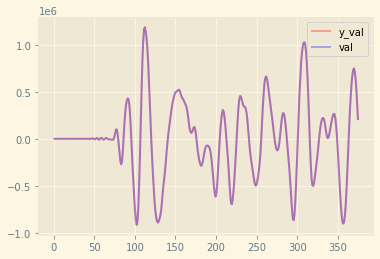

In [80]:
#분할 잘 되었는지 확인
confirm(new_train, y_new_train, 3, 0)

In [81]:
#50 ticks
new_train_50 = noise_delete(new_train, 0, 50)
new_test_50 = noise_delete(new_test, 0, 50)

#100 ticks
new_train_100 = noise_delete(new_train, 0, 100)
new_test_100 = noise_delete(new_test, 0, 100)

#150 ticks
new_train_150 = noise_delete(new_train, 0, 150)
new_test_150 = noise_delete(new_test, 0, 150)

#200 ticks
new_train_200 = noise_delete(new_train, 0, 200)
new_test_200 = noise_delete(new_test, 0, 200)

#375 ticks
new_train_375 = noise_delete(new_train, 0, 375)
new_test_375 = noise_delete(new_test, 0, 375)


In [82]:
#함수 적용
##50
X_new_train_50 = feature_generation(new_train_50, y_new_train)
X_new_train_50.columns=['max_amp_50_S1','max_amp_50_S2','max_amp_50_S3','max_amp_50_S4', 'mean_amp_50_S1', 'mean_amp_50_S2', 'mean_amp_50_S3', 'mean_amp_50_S4', "MAP_freq_50_S1", "MAP_freq_50_S2", "MAP_freq_50_S3", "MAP_freq_50_S4"]

X_new_test_50 = feature_generation(new_test_50, y_new_test)
X_new_test_50.columns=['max_amp_50_S1','max_amp_50_S2','max_amp_50_S3','max_amp_50_S4', 'mean_amp_50_S1', 'mean_amp_50_S2', 'mean_amp_50_S3', 'mean_amp_50_S4', "MAP_freq_50_S1", "MAP_freq_50_S2", "MAP_freq_50_S3", "MAP_freq_50_S4"]

##100
X_new_train_100 = feature_generation(new_train_100, y_new_train)
X_new_train_100.columns=['max_amp_100_S1','max_amp_100_S2','max_amp_100_S3','max_amp_100_S4', 'mean_amp_100_S1', 'mean_amp_100_S2', 'mean_amp_100_S3', 'mean_amp_100_S4', "MAP_freq_100_S1", "MAP_freq_100_S2", "MAP_freq_100_S3", "MAP_freq_100_S4"]

X_new_test_100 = feature_generation(new_test_100, y_new_test)
X_new_test_100.columns=['max_amp_100_S1','max_amp_100_S2','max_amp_100_S3','max_amp_100_S4', 'mean_amp_100_S1', 'mean_amp_100_S2', 'mean_amp_100_S3', 'mean_amp_100_S4', "MAP_freq_100_S1", "MAP_freq_100_S2", "MAP_freq_100_S3", "MAP_freq_100_S4"]

##150
X_new_train_150 = feature_generation(new_train_150, y_new_train)
X_new_train_150.columns=['max_amp_150_S1','max_amp_150_S2','max_amp_150_S3','max_amp_150_S4', 'mean_amp_150_S1', 'mean_amp_150_S2', 'mean_amp_150_S3', 'mean_amp_150_S4', "MAP_freq_150_S1", "MAP_freq_150_S2", "MAP_freq_150_S3", "MAP_freq_150_S4"]

X_new_test_150 = feature_generation(new_test_150, y_new_test)
X_new_test_150.columns=['max_amp_150_S1','max_amp_150_S2','max_amp_150_S3','max_amp_150_S4', 'mean_amp_150_S1', 'mean_amp_150_S2', 'mean_amp_150_S3', 'mean_amp_150_S4', "MAP_freq_150_S1", "MAP_freq_150_S2", "MAP_freq_150_S3", "MAP_freq_150_S4"]

##200
X_new_train_200 = feature_generation(new_train_200, y_new_train)
X_new_train_200.columns=['max_amp_200_S1','max_amp_200_S2','max_amp_200_S3','max_amp_200_S4', 'mean_amp_200_S1', 'mean_amp_200_S2', 'mean_amp_200_S3', 'mean_amp_200_S4', "MAP_freq_200_S1", "MAP_freq_200_S2", "MAP_freq_200_S3", "MAP_freq_200_S4"]

X_new_test_200 = feature_generation(new_test_200, y_new_test)
X_new_test_200.columns=['max_amp_200_S1','max_amp_200_S2','max_amp_200_S3','max_amp_200_S4', 'mean_amp_200_S1', 'mean_amp_200_S2', 'mean_amp_200_S3', 'mean_amp_200_S4', "MAP_freq_200_S1", "MAP_freq_200_S2", "MAP_freq_200_S3", "MAP_freq_200_S4"]

##375
X_new_train_375 = feature_generation(new_train_375, y_new_train)
X_new_train_375.columns=['max_amp_375_S1','max_amp_375_S2','max_amp_375_S3','max_amp_375_S4', 'mean_amp_375_S1', 'mean_amp_375_S2', 'mean_amp_375_S3', 'mean_amp_375_S4', "MAP_freq_375_S1", "MAP_freq_375_S2", "MAP_freq_375_S3", "MAP_freq_375_S4"]

X_new_test_375 = feature_generation(new_test_375, y_new_test)
X_new_test_375.columns=['max_amp_375_S1','max_amp_375_S2','max_amp_375_S3','max_amp_375_S4', 'mean_amp_375_S1', 'mean_amp_375_S2', 'mean_amp_375_S3', 'mean_amp_375_S4', "MAP_freq_375_S1", "MAP_freq_375_S2", "MAP_freq_375_S3", "MAP_freq_375_S4"]

In [83]:
#featrue 생성

thr_new_train = first_threshold(new_train, y_new_train, 0)
thr_new_test = first_threshold(new_test, y_new_test, 0)

In [84]:
X_new_train = pd.concat([X_new_train_50, X_new_train_100, X_new_train_150, X_new_train_200, X_new_train_375, thr_new_train], axis = 1)
X_new_test = pd.concat([X_new_test_50, X_new_test_100, X_new_test_150, X_new_test_200, X_new_test_375, thr_new_test], axis = 1)


In [85]:

xgboost3 = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=70,
        random_state=42,
        n_jobs=-1,
        max_depth=3,
        learning_rate=0.01385,
        
        )

xgboost3.fit(X_new_train, y_new_train['Caution'])


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01385, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [86]:
cau_xgboost3_pred = xgboost3.predict(X_train)
print_score2(cau_xgboost3_pred, y_train, 'XGBoost')


Caution label predict XGBoost recall  0.9728682170542635
Caution label predict XGBoost precision  0.974757281553398
Caution label predict XGBoost f1  0.9738118331716779


## 선형성 높은 특성 제거

In [87]:
xgboost4 = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=150,
        random_state=42,
        n_jobs=-1,
        max_depth=3,
        learning_rate=0.0173,
        early_stopping_rounds=25,
        )

watchlist = [(X_train_re, y_train['Caution']), (X_val_re, y_val['Caution'])]

xgboost4.fit(
    X_train_re,
    y_train['Caution'],
    eval_set=watchlist,
      
)
cau_xgboost4_pred = xgboost4.predict(X_train_re)
print_score2(cau_xgboost4_pred, y_train, 'XGBoost')
cau_xgboost4_pred_v = xgboost4.predict(X_val_re)
print_score2(cau_xgboost4_pred_v, y_val, 'XGBoost')

[0]	validation_0-auc:0.98747	validation_1-auc:0.97215
[1]	validation_0-auc:0.99562	validation_1-auc:0.98047
[2]	validation_0-auc:0.99634	validation_1-auc:0.97620
[3]	validation_0-auc:0.99654	validation_1-auc:0.97989
[4]	validation_0-auc:0.99655	validation_1-auc:0.97989
[5]	validation_0-auc:0.99651	validation_1-auc:0.97989
[6]	validation_0-auc:0.99682	validation_1-auc:0.97989
[7]	validation_0-auc:0.99683	validation_1-auc:0.98018
[8]	validation_0-auc:0.99684	validation_1-auc:0.98018
[9]	validation_0-auc:0.99700	validation_1-auc:0.97960
[10]	validation_0-auc:0.99719	validation_1-auc:0.98032
[11]	validation_0-auc:0.99728	validation_1-auc:0.97891
[12]	validation_0-auc:0.99741	validation_1-auc:0.97935
[13]	validation_0-auc:0.99739	validation_1-auc:0.97884
[14]	validation_0-auc:0.99745	validation_1-auc:0.97884
[15]	validation_0-auc:0.99743	validation_1-auc:0.97862
[16]	validation_0-auc:0.99746	validation_1-auc:0.97862
[17]	validation_0-auc:0.99746	validation_1-auc:0.97862
[18]	validation_0-au

## 새 섹션

In [88]:
test_data

,id,Time,S1,S2,S3,S4
0,2800,0.000000,0.00,0.00,0.00,0.0
1,2800,0.000004,0.00,0.00,0.00,0.0
2,2800,0.000008,0.00,0.00,0.00,0.0
3,2800,0.000012,0.00,0.00,0.00,0.0
4,2800,0.000016,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...
262495,3499,0.001480,-87378.88,118549.40,-54152.05,103566.8
262496,3499,0.001484,-69470.29,111936.70,-57300.99,125860.6
262497,3499,0.001488,-50610.34,98222.38,-58903.99,139689.6
262498,3499,0.001492,-34555.25,81393.17,-57897.30,142507.4


## 대회에서 제공된 평가 지표

거리 예측 오차 & 속도, 질량 예측 mse 를 더해서 점수를 매기는 평가 지표
<br/>프로젝트를 진행하면서 속도, 질량 예측을 빼고 새롭게 라벨을 생성해서 분류 문제로 진행했기 때문에 대회 주최자의 의도에 맞게 사용할 수는 없음.
<br/>하지만 caution 값을 0,1 계산 가능한 정수로 설정 했기 때문에 속도, 질량 mse를 계산하는 식에 대입은 가능함
<br/>그냥 kaeri_metric 값이 오차를 계산한 것으로 클수록 성능이 좋지 않다고 참고 정도로만 사용

In [89]:


def kaeri_metric(y_true, y_pred):
    
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: KAERI metric
    '''
    
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)


### E1과 E2는 아래에 정의됨 ###

def E1(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)


def E2(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    
    _t, _p = np.array(y_true)[:,3:], np.array(y_pred)[:,3:]
    
    
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))

In [90]:
pd.options.display.float_format = '{: .2f}'.format 
y_pred = pd.DataFrame()
y_pred['X'] = pd.DataFrame(X_pos_val_lasso_pred)
y_pred['Y'] = pd.DataFrame(Y_pos_val_lasso_pred)
y_pred['Caution'] = xgboost.predict(X_val)

In [91]:
y_pred2 = pd.DataFrame()
y_pred2['X'] = pd.DataFrame(X_pos_train_lasso_pred)
y_pred2['Y'] = pd.DataFrame(Y_pos_train_lasso_pred)
y_pred2['Caution'] = xgboost.predict(X_train)

In [92]:
kaeri_metric(y_train.drop(columns=['M', 'V', 'P']), y_pred2)

69.53753081704215

In [93]:
kaeri_metric(y_val.drop(columns=['M', 'V', 'P']), y_pred)

73.90662321708267

#7. test 셋에 적용하여 일반화 성능 검증하기

X position

In [94]:
X_pos_val_reduced_multi_score.columns = ['Multiple']
X_pos_val_lasso_score.columns = ['Lasso']
X_pos_val_ridge_score.columns = ['Ridge']

Text(0.5, 0.98, 'X position error')

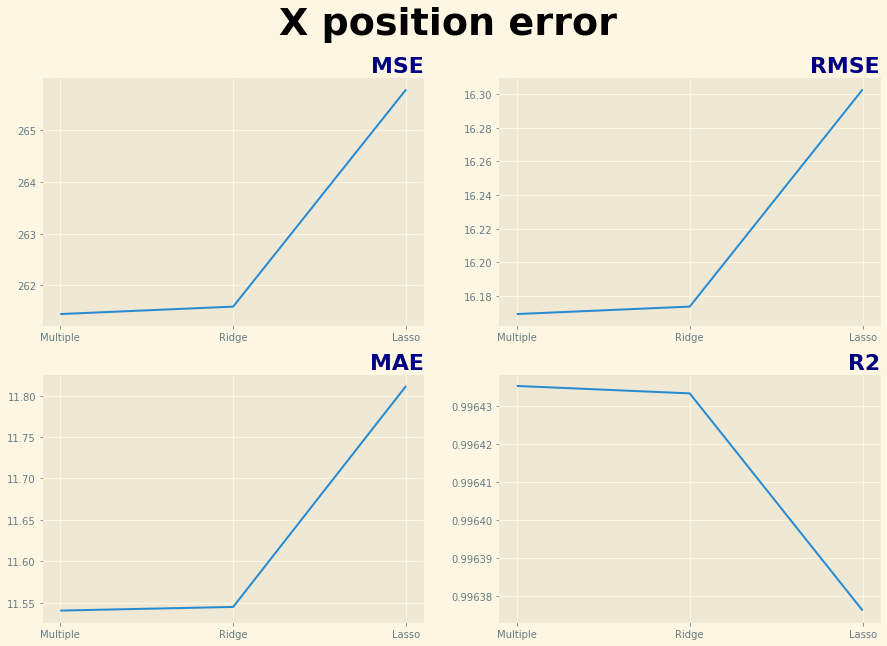

In [95]:
X_score = pd.concat([X_pos_val_reduced_multi_score, X_pos_val_ridge_score, X_pos_val_lasso_score], axis =1)


plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(X_score.loc['mse'])
plt.title('MSE', fontdict = title_font, loc='right')

plt.subplot(2, 2, 2)
plt.plot(X_score.loc['rmse'])
plt.title('RMSE', fontdict = title_font, loc='right')

plt.subplot(2, 2, 3)
plt.plot(X_score.loc['mae'])
plt.title('MAE', fontdict = title_font, loc='right')

plt.subplot(2, 2, 4)
plt.plot(X_score.loc['r2'])
plt.title('R2', fontdict = title_font, loc='right')

plt.suptitle('X position error', fontsize =38, fontweight= 'bold')



multiple linear regression 모델 선택

In [96]:
#X position 일반화 성능

X_pos_test_pred = X_pos_multi_re.predict(X_test_re_x_s)
print_score(X_pos_test_pred, y_test, 'X', 'Multiple Linear Regression', 'X_test')


X_test set X  position  Multiple Linear Regression mse  216.71358639049024
X_test set X  position  Multiple Linear Regression rmse  14.721195141376608
X_test set X  position  Multiple Linear Regression mae  10.748998520374258
X_test set X  position  Multiple Linear Regression r2  0.9968567442329155


Y position

In [97]:
Y_pos_val_reduced_multi_score.columns = ['Multiple']
Y_pos_val_ridge_score.columns = ['Lasso']
Y_pos_val_lasso_score.columns = ['Ridge']

Text(0.5, 0.98, 'Y position error')

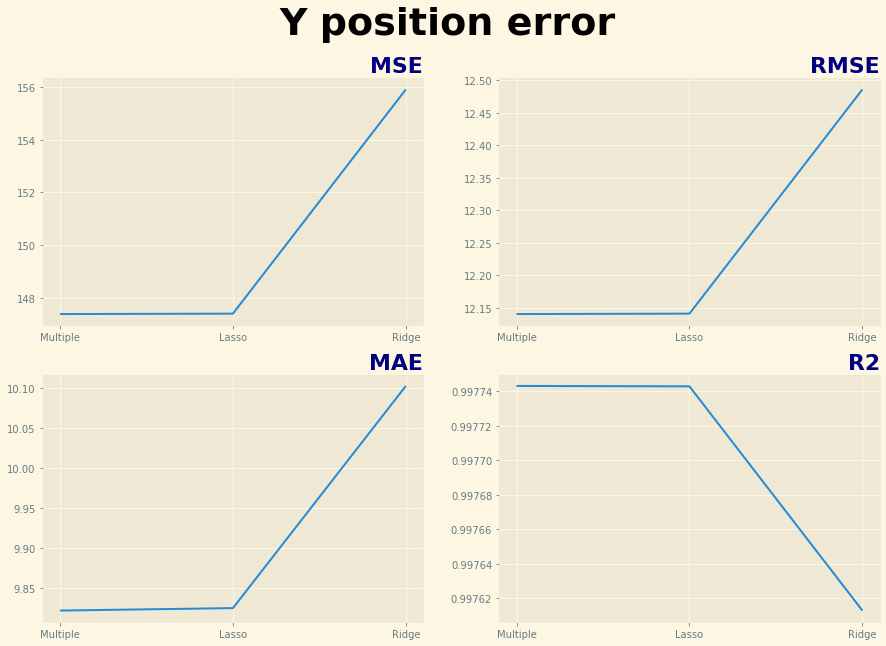

In [98]:
Y_score = pd.concat([Y_pos_val_reduced_multi_score, Y_pos_val_ridge_score, Y_pos_val_lasso_score], axis =1)


plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(Y_score.loc['mse'])
plt.title('MSE', fontdict = title_font, loc='right')

plt.subplot(2, 2, 2)
plt.plot(Y_score.loc['rmse'])
plt.title('RMSE', fontdict = title_font, loc='right')

plt.subplot(2, 2, 3)
plt.plot(Y_score.loc['mae'])
plt.title('MAE', fontdict = title_font, loc='right')

plt.subplot(2, 2, 4)
plt.plot(Y_score.loc['r2'])
plt.title('R2', fontdict = title_font, loc='right')

plt.suptitle('Y position error', fontsize =38, fontweight= 'bold')


multiple linear regression 모델 선택

In [99]:
#Y position 일반화 성능

Y_pos_test_pred = Y_pos_multi_re_y.predict(X_test_re_y_s)
print_score(Y_pos_test_pred, y_test, 'Y', 'Multiple Linear Regression', 'X_test')


X_test set Y  position  Multiple Linear Regression mse  161.9359159720094
X_test set Y  position  Multiple Linear Regression rmse  12.725404353968852
X_test set Y  position  Multiple Linear Regression mae  10.105576797318713
X_test set Y  position  Multiple Linear Regression r2  0.9974289768468707


xgboost4 번 모델 선택

In [100]:
X_train_re.columns

Index(['max_amp_50_S1', 'max_amp_50_S2', 'max_amp_50_S3', 'max_amp_50_S4',
       'MAP_freq_50_S1', 'MAP_freq_50_S2', 'MAP_freq_50_S3', 'MAP_freq_50_S4',
       'max_amp_100_S1', 'max_amp_100_S2', 'max_amp_100_S3', 'max_amp_100_S4',
       'MAP_freq_100_S1', 'MAP_freq_100_S2', 'MAP_freq_100_S3',
       'MAP_freq_100_S4', 'max_amp_150_S1', 'max_amp_150_S2', 'max_amp_150_S3',
       'max_amp_150_S4', 'MAP_freq_150_S1', 'MAP_freq_150_S2',
       'MAP_freq_150_S3', 'MAP_freq_150_S4', 'max_amp_200_S1',
       'max_amp_200_S2', 'max_amp_200_S3', 'max_amp_200_S4', 'MAP_freq_200_S1',
       'MAP_freq_200_S2', 'MAP_freq_200_S3', 'MAP_freq_200_S4',
       'max_amp_375_S1', 'max_amp_375_S2', 'max_amp_375_S3', 'max_amp_375_S4',
       'MAP_freq_375_S1', 'MAP_freq_375_S2', 'MAP_freq_375_S3',
       'MAP_freq_375_S4', 'S1_thr', 'S2_thr', 'S3_thr', 'S4_thr', 'S1-S2',
       'S1-S3', 'S1-S4', 'S2-S3', 'S2-S4', 'S3-S4'],
      dtype='object')

In [101]:
X_train_re = X_train.copy().drop(columns = X_train.columns[X_train.columns.str.contains('mean')])
X_val_re = X_val.copy().drop(columns = X_val.columns[X_val.columns.str.contains('mean')])
X_test_re = X_test.copy().drop(columns = X_test.columns[X_test.columns.str.contains('mean')])

X_train_re = X_train_re.drop(columns=['S1-S2', 'S1-S3', 'S1-S4', 'S2-S3', 'S2-S4', 'S3-S4'])
X_val_re = X_val_re.drop(columns=['S1-S2', 'S1-S3', 'S1-S4', 'S2-S3', 'S2-S4', 'S3-S4'])
X_test_re = X_test_re.drop(columns=['S1-S2', 'S1-S3', 'S1-S4', 'S2-S3', 'S2-S4', 'S3-S4'])


X_train_re = X_train_re.drop(columns = X_train_re.columns[X_train_re.columns.str.contains('thr')])
X_val_re = X_val_re.drop(columns = X_val_re.columns[X_val_re.columns.str.contains('thr')])
X_test_re = X_test_re.drop(columns = X_test_re.columns[X_test_re.columns.str.contains('thr')])

X_train_re = X_train_re.drop(columns = X_train_re.columns[X_train_re.columns.str.contains('max_amp_50')])
X_val_re = X_val_re.drop(columns = X_val_re.columns[X_val_re.columns.str.contains('max_amp_50')])
X_test_re = X_test_re.drop(columns = X_test_re.columns[X_test_re.columns.str.contains('max_amp_50')])

X_train_re = X_train_re.drop(columns = X_train_re.columns[X_train_re.columns.str.contains('max_amp_100')])
X_val_re = X_val_re.drop(columns = X_val_re.columns[X_val_re.columns.str.contains('max_amp_100')])
X_test_re = X_test_re.drop(columns = X_test_re.columns[X_test_re.columns.str.contains('max_amp_100')])


X_train_re = X_train_re.drop(columns = X_train_re.columns[X_train_re.columns.str.contains('max_amp_150')])
X_val_re = X_val_re.drop(columns = X_val_re.columns[X_val_re.columns.str.contains('max_amp_150')])
X_test_re = X_test_re.drop(columns = X_test_re.columns[X_test_re.columns.str.contains('max_amp_150')])


X_train_re = X_train_re.drop(columns = X_train_re.columns[X_train_re.columns.str.contains('max_amp_375')])
X_val_re = X_val_re.drop(columns = X_val_re.columns[X_val_re.columns.str.contains('max_amp_375')])
X_test_re = X_test_re.drop(columns = X_test_re.columns[X_test_re.columns.str.contains('max_amp_375')])

X_train_re = X_train_re.drop(columns = X_train_re.columns[X_train_re.columns.str.contains('MAP_freq_50')])
X_val_re = X_val_re.drop(columns = X_val_re.columns[X_val_re.columns.str.contains('MAP_freq_50')])
X_test_re = X_test_re.drop(columns = X_test_re.columns[X_test_re.columns.str.contains('MAP_freq_50')])


X_train_re = X_train_re.drop(columns = X_train_re.columns[X_train_re.columns.str.contains('MAP_freq_375')])
X_val_re = X_val_re.drop(columns = X_val_re.columns[X_val_re.columns.str.contains('MAP_freq_375')])
X_test_re = X_test_re.drop(columns = X_test_re.columns[X_test_re.columns.str.contains('MAP_freq_375')])

X_train_re = X_train_re.drop(columns = ['MAP_freq_100_S1','MAP_freq_100_S2','MAP_freq_150_S1','MAP_freq_150_S2', 'MAP_freq_150_S3', 'MAP_freq_150_S4','MAP_freq_200_S3'])
X_val_re = X_val_re.drop(columns = ['MAP_freq_100_S1','MAP_freq_100_S2','MAP_freq_150_S1','MAP_freq_150_S2', 'MAP_freq_150_S3', 'MAP_freq_150_S4','MAP_freq_200_S3'])
X_test_re = X_test_re.drop(columns =['MAP_freq_100_S1','MAP_freq_100_S2','MAP_freq_150_S1','MAP_freq_150_S2', 'MAP_freq_150_S3', 'MAP_freq_150_S4','MAP_freq_200_S3'])



In [102]:

xgboost4 = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=150,
        random_state=42,
        n_jobs=-1,
        max_depth=3,
        learning_rate=0.0173,
        early_stopping_rounds=25,
        )

watchlist = [(X_train_re, y_train['Caution']), (X_val_re, y_val['Caution'])]

xgboost4.fit(
    X_train_re,
    y_train['Caution'],
    eval_set=watchlist,
      
)
cau_xgboost4_pred = xgboost4.predict(X_train_re)
print_score2(cau_xgboost4_pred, y_train, 'XGBoost')
cau_xgboost4_pred_v = xgboost4.predict(X_val_re)
print_score2(cau_xgboost4_pred_v, y_val, 'XGBoost')

[0]	validation_0-auc:0.99270	validation_1-auc:0.97953
[1]	validation_0-auc:0.99270	validation_1-auc:0.97953
[2]	validation_0-auc:0.99332	validation_1-auc:0.97971
[3]	validation_0-auc:0.99432	validation_1-auc:0.97964
[4]	validation_0-auc:0.99441	validation_1-auc:0.97964
[5]	validation_0-auc:0.99440	validation_1-auc:0.97964
[6]	validation_0-auc:0.99441	validation_1-auc:0.97964
[7]	validation_0-auc:0.99440	validation_1-auc:0.97964
[8]	validation_0-auc:0.99439	validation_1-auc:0.97964
[9]	validation_0-auc:0.99460	validation_1-auc:0.97964
[10]	validation_0-auc:0.99488	validation_1-auc:0.97993
[11]	validation_0-auc:0.99487	validation_1-auc:0.97993
[12]	validation_0-auc:0.99489	validation_1-auc:0.97993
[13]	validation_0-auc:0.99458	validation_1-auc:0.97819
[14]	validation_0-auc:0.99489	validation_1-auc:0.97993
[15]	validation_0-auc:0.99458	validation_1-auc:0.97819
[16]	validation_0-auc:0.99489	validation_1-auc:0.97993
[17]	validation_0-auc:0.99467	validation_1-auc:0.97815
[18]	validation_0-au

In [103]:
!pip3 install eli5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 14.1 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=1c481a767aa23d62459566f48872a5762fae229864f170e04f33aeb958764eba
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib

In [104]:
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    xgboost4,
    scoring="recall",  
    n_iter=10,  
    random_state=2,
)

permuter.fit(X_train_re, y_train['Caution'])

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=25,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.0173, max_bin=256,
                        

Text(0.5, 1.0, 'Permutation Importance')

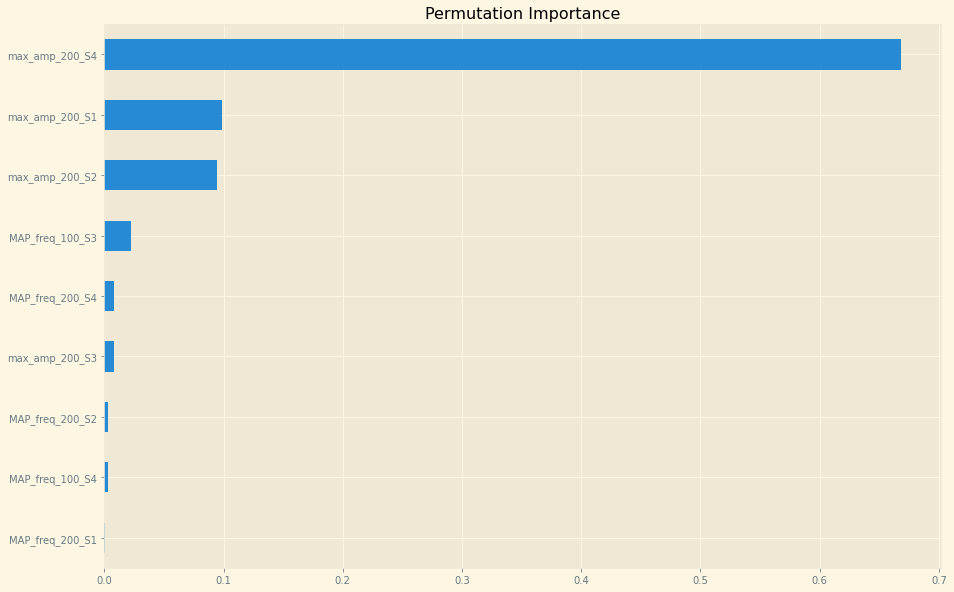

In [105]:
feature_names = X_train_re.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
plt.figure(figsize = (15, 10))
pi.plot.barh()
plt.title("Permutation Importance")

In [114]:
!pip install pdpbox


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PDPbox-0.2.1.tar.gz (34.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached matplotlib-3.1.1.tar.gz (37.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=431efac9b283512dae52e81e4ba9dc9aeaa37473598d50f6873963423232b561
  Stored in directory: /root/.cache/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-linux_x86_64.whl size=12090041 sha256=931679d587f76ea6894442689b868e64da6417d5f8a541c0e59febb5a72c5d77
  Stored in directory: /root/.cache/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=abb725a

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6f86a2baf0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6f8666f460>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6f8661b580>}})

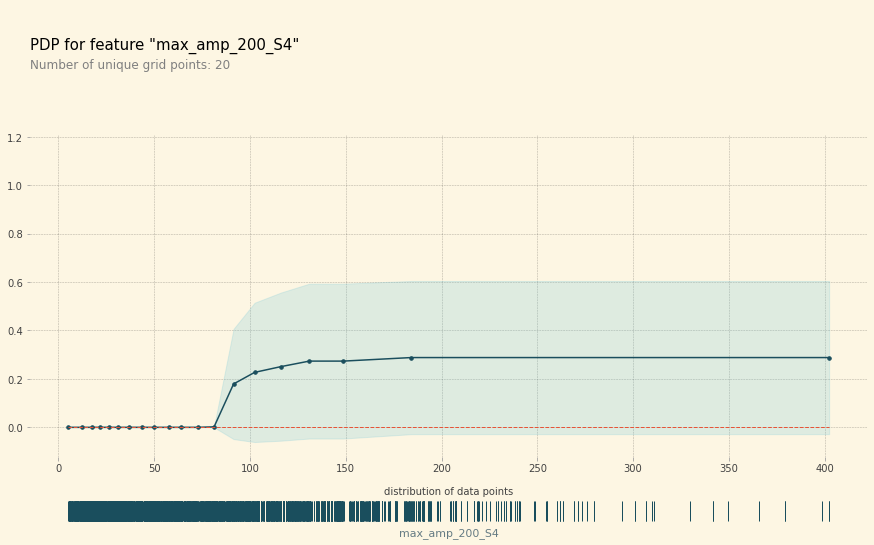

In [115]:
from pdpbox.pdp import pdp_isolate, pdp_plot


isolated = pdp_isolate(
    model=xgboost4,
    dataset=X_train_re,
    model_features=X_train_re.columns,
    feature='max_amp_200_S4',
    grid_type="percentile",  
    num_grid_points=20,
    
)
pdp_plot(isolated, feature_name='max_amp_200_S4',plot_pts_dist = True)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6f865abee0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6f8655aa30>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6f86586df0>}})

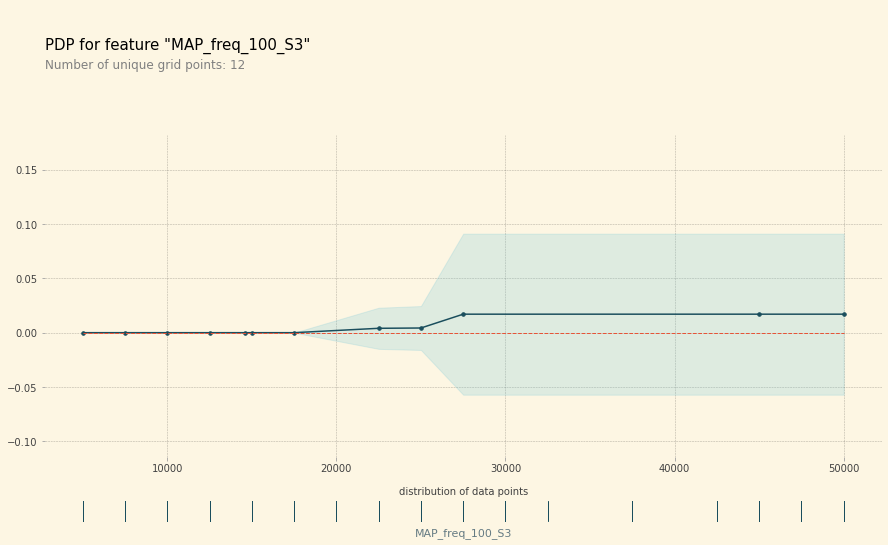

In [116]:

isolated = pdp_isolate(
    model=xgboost4,
    dataset=X_train_re,
    model_features=X_train_re.columns,
    feature='MAP_freq_100_S3',
    grid_type="percentile",  
    num_grid_points=20,
    
)
pdp_plot(isolated, feature_name='MAP_freq_100_S3',plot_pts_dist = True)

In [117]:
cau_xgboost4_pred = xgboost4.predict(X_test_re)
print_score2(cau_xgboost4_pred, y_test, 'XGBoost')
print(roc_auc_score(y_test['Caution'], xgboost4.predict_proba(X_test_re)[:,1]))

Caution label predict XGBoost recall  0.9666666666666667
Caution label predict XGBoost precision  0.9666666666666667
Caution label predict XGBoost f1  0.9666666666666667
0.99921875
